# Import Libraries


In [1]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import pickle
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

2025-06-13 11:34:30.389974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749789270.403122   67911 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749789270.407297   67911 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749789270.417050   67911 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749789270.417068   67911 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749789270.417070   67911 computation_placer.cc:177] computation placer alr

# Load Essay Dataset

In [2]:
stdset = pd.read_csv("datasets_ta/esai_siswa.csv")
gpt1set = pd.read_csv("datasets_ta/esai_gpt_new.csv")
gpt2set = pd.read_csv("datasets_ta/pengetahuan_gpt_new.csv")

In [3]:
stdset.info()
stdset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Essay   135 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


,Essay
0,Selama berlibur dan bulan suci Ramadhan saya p...
1,selama bulan Ramadhan saya membantu orang tua ...
2,"Assalamualaikum, selama bulan suci Ramadhan sa..."
3,Selama libur idul Fitri sayaa hanya tidur teta...
4,Assalamu'alaikum warahmatullahi waabarakatuh \...


In [4]:
gpt1set.info()
gpt1set.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Response  135 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


,Response
0,"Selama libur Idul Fitri tahun ini, saya merasa..."
1,"Selama libur Idul Fitri tahun ini, teknologi m..."
2,Libur Idul Fitri tahun ini terasa begitu berbe...
3,"Libur Idul Fitri tahun ini, saya memanfaatkan ..."
4,"Selama libur Idul Fitri tahun ini, saya mengal..."


In [5]:
gpt2set.info()
gpt2set.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Response  135 non-null    object
 1   Bab       135 non-null    object
dtypes: object(2)
memory usage: 2.2+ KB


,Response,Bab
0,Perencanaan kerja kelompok yang efektif memerl...,Bab 1
1,Perencanaan kerja kelompok yang efektif membut...,Bab 1
2,Perencanaan kerja kelompok yang efektif memerl...,Bab 1
3,Perencanaan kerja kelompok yang efektif sangat...,Bab 1
4,Perencanaan kerja kelompok yang efektif memerl...,Bab 1


In [6]:
def preprocess_sentence(text):
    """
    Text preprocessing:
    - Convert text to lowercase
    - Split text into sentences using regex
    - Retain sentences even if they do not end with standard punctuation

    Args:
        text (str): Input text.

    Returns:
        list: List of cleaned sentences.
    """
    if not isinstance(text, str) or text.strip() == "":
        return []

    text = text.lower().strip()
    sentences = re.findall(r'[^.!?]+(?:[.!?…]+)?', text)
    cleaned_sentences = [s.strip() for s in sentences if s.strip()]

    return cleaned_sentences


# Load Dataset for Training

In [7]:
std_sen = []
gpt1_sen = []  
gpt2_sen = []

for text in stdset['Essay']:
    std_sen.extend(preprocess_sentence(text))

for text in gpt1set['Response']:
    gpt1_sen.extend(preprocess_sentence(text))

for text in gpt2set['Response']:
    gpt2_sen.extend(preprocess_sentence(text))


# Create DataFrames with text and labels
std_df = pd.DataFrame({'text': std_sen, 'label': 0})
gpt1_df = pd.DataFrame({'text': gpt1_sen, 'label': 1})
gpt2_df = pd.DataFrame({'text': gpt2_sen, 'label': 2})

# Combine all data
data = pd.concat([std_df, gpt1_df, gpt2_df], ignore_index=True)

# Print statistics
print(f"Total student essay sentences: {len(std_sen)} (label=0)")
print(f"Total ChatGPT essay sentences: {len(gpt1_sen)} (label=1)")
print(f"Total ChatGPT knowledge sentences: {len(gpt2_sen)} (label=2)")
print(f"Total combined data: {len(data)}")

# Display first few rows of combined data
print("\nFirst few rows of combined data:")
pd.set_option('display.max_colwidth', None)
display(data.head())

Total student essay sentences: 1023 (label=0)
Total ChatGPT essay sentences: 2113 (label=1)
Total ChatGPT knowledge sentences: 2282 (label=2)
Total combined data: 5418

First few rows of combined data:


,text,label
0,"selama berlibur dan bulan suci ramadhan saya pulang kampung, setelah di kampung, saya sering ke masjid tarawih dan tadarusan bersama teman kampung saya, setelah tadarus kami melanjutkan dengan membangunkan sahur orang' di kampung, saya dan teman-teman sering bermain free fire sambil menunggu waktu berbuka,selain itu saya juga membantu bapak saya di kebun, kemudian di malam idul fitri saya dan orang kampung saya melakukan takbiran keliling kampung.",0
1,"selama bulan ramadhan saya membantu orang tua saya, saya juga mengikuti solat tarawih, buka bersama, saat lebaran saya bertemu teman dan keluarga saya, kami meminta maaf satu sama lainnya lalu kami berbincang""sebelumnya saya menunggu waktu berbuka sambil nnton tiktok dan rells ig.",0
2,"saya juga ikut melakukan kegiatan berbagi takjil bersama anggota osis di sekolah, kami melakukannya bersama"" kamu membuat es timun serut, lalu kami membagikannya di simpang tiga dekat dengan sekolah kami,",0
3,"assalamualaikum, selama bulan suci ramadhan saya sering pergi teraweh sama teman teman dan setelah teraweh saya melakukan tadarus, dan selama bulan suci ramadhan saya tinggal jauh sama orang tua tetapi orang tua saya datang saat idul fitri sudah dekat untuk melakukan idul fitri di sumbawa bersama saya setelah melakukan idul fitri saya mudik ke lombok bersama keluarga sekalian menikmati libur saat di di lombok saya juga pergi liburan ke mandalika dan setelah mau masuk sekolah saya kembali ke sumbawa untuk sekolah sekian dari saya terimakasih assalamualaikum",0
4,"selama libur idul fitri sayaa hanya tidur tetapi terkadang saya juga membantu mama saya membereskan rumah,lalu malamnyaa saya trawehh,sehabis trawe saya jalan' dngn teman' saya sambil mnunggu jam sahur,stelah jam sahur kami membangunkan orang sahur dengn menggunakan speaker.",0


# Data Splitting
- Training 75%
- Validation 5%
- Testing 20%

In [8]:
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['label']
)

print(f"Initial training set: {len(train_data)} samples")
print(f"Initial test set: {len(test_data)} samples")
print(f"Initial training distribution: Student={sum(train_data['label']==0)}, ChatGPT={sum(train_data['label']==1)}, ChatGPT_Knowledge={sum(train_data['label']==2)}")
print(f"Initial test distribution: Student={sum(test_data['label']==0)}, ChatGPT={sum(test_data['label']==1)}, ChatGPT_Knowledge={sum(test_data['label']==2)}")

X_train = train_data[['text']]
y_train = train_data['label']

undersampler = RandomUnderSampler(random_state=42)
X_train_indices = pd.DataFrame({'index': range(len(X_train))})
X_resampled_indices, y_resampled = undersampler.fit_resample(X_train_indices, y_train)

selected_indices = X_resampled_indices['index'].values

balanced_train_data = train_data.iloc[selected_indices].reset_index(drop=True)

removed_indices = set(range(len(train_data))) - set(selected_indices)
removed_samples = train_data.iloc[list(removed_indices)]

test_set = pd.concat([test_data, removed_samples]).reset_index(drop=True)
test_set = test_set.sort_values(by='label').reset_index(drop=True)

# Create perfectly balanced validation set manually
val_per_class = 51  # or any number that divides evenly
val_indices = []

for label in balanced_train_data['label'].unique():
    label_indices = balanced_train_data[balanced_train_data['label'] == label].index[:val_per_class]
    val_indices.extend(label_indices)

val_set = balanced_train_data.loc[val_indices].reset_index(drop=True)
train_set = balanced_train_data.drop(val_indices).reset_index(drop=True)

# Sort by label
train_set = train_set.sort_values(by='label').reset_index(drop=True)
val_set = val_set.sort_values(by='label').reset_index(drop=True)

# Print final dataset statistics
print("\nAfter undersampling:")
print(f"Training set: {len(train_set)} samples (Student={sum(train_set['label']==0)}, ChatGPT={sum(train_set['label']==1)}, ChatGPT_Knowledge={sum(train_set['label']==2)})")
print(f"Validation set: {len(val_set)} samples (Student={sum(val_set['label']==0)}, ChatGPT={sum(val_set['label']==1)}, ChatGPT_Knowledge={sum(val_set['label']==2)})")
print(f"Test set: {len(test_set)} samples (Student={sum(test_set['label']==0)}, ChatGPT={sum(test_set['label']==1)}, ChatGPT_Knowledge={sum(test_set['label']==2)})")


Initial training set: 4334 samples
Initial test set: 1084 samples
Initial training distribution: Student=818, ChatGPT=1690, ChatGPT_Knowledge=1826
Initial test distribution: Student=205, ChatGPT=423, ChatGPT_Knowledge=456

After undersampling:
Training set: 2301 samples (Student=767, ChatGPT=767, ChatGPT_Knowledge=767)
Validation set: 153 samples (Student=51, ChatGPT=51, ChatGPT_Knowledge=51)
Test set: 2964 samples (Student=205, ChatGPT=1295, ChatGPT_Knowledge=1464)


# Initialize BERT Tokenizer

In [9]:
# Initialize IndoBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenize function
def tokenize_text(texts, max_length=128):
    """
    Text tokenization using IndoBERT tokenizer.
    
    Args:
        texts (list): List of texts to be tokenized.
        max_length (int): Maximum token length.
        
    Returns:
        dict: Tokenized result, including input_ids and attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [10]:
# Tokenize student and ChatGPT essays
print("Tokenize student essay...")
std_tokens = tokenize_text(std_sen)
print("Tokenize ChatGPT essay...")
gpt1_tokens = tokenize_text(gpt1_sen)

print("Tokenize ChatGPT knowledge essay...")
gpt2_tokens = tokenize_text(gpt2_sen)

print("Tokenize student essay (Training Set)...")
std_tr_tokens = tokenize_text(train_set[train_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Training Set)...")
gpt1_tr_tokens = tokenize_text(train_set[train_set['label'] == 1]['text'].tolist())
print("Tokenize ChatGPT knowledge (Training Set)...")
gpt2_tr_tokens = tokenize_text(train_set[train_set['label'] == 2]['text'].tolist())

print("Tokenize student essay (Validation Set)...")
std_va_tokens = tokenize_text(val_set[val_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Validation Set)...")
gpt1_va_tokens = tokenize_text(val_set[val_set['label'] == 1]['text'].tolist())
print("Tokenize ChatGPT knowledge (Validation Set)...")
gpt2_va_tokens = tokenize_text(val_set[val_set['label'] == 2]['text'].tolist())

print("Tokenize student essay (Test Set)...")
std_te_tokens = tokenize_text(test_set[test_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Test Set)...")
gpt1_te_tokens = tokenize_text(test_set[test_set['label'] == 1]['text'].tolist())
print("Tokenize ChatGPT knowledge (Test Set)...")
gpt2_te_tokens = tokenize_text(test_set[test_set['label'] == 2]['text'].tolist())

# Display tokenization results (example: Student)
print("\nExample of tokenization results:")
print(std_tr_tokens['input_ids'][:3])  # Input token ID
print(std_tr_tokens['attention_mask'][:3])  # Attention mask

Tokenize student essay...


I0000 00:00:1749789275.376106   67911 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Tokenize ChatGPT essay...
Tokenize ChatGPT knowledge essay...
Tokenize student essay (Training Set)...
Tokenize ChatGPT essay (Training Set)...
Tokenize ChatGPT knowledge (Training Set)...
Tokenize student essay (Validation Set)...
Tokenize ChatGPT essay (Validation Set)...
Tokenize ChatGPT knowledge (Validation Set)...
Tokenize student essay (Test Set)...
Tokenize ChatGPT essay (Test Set)...
Tokenize ChatGPT knowledge (Test Set)...

Example of tokenization results:
tf.Tensor(
[[    2   751    90 29329 10361 30468   209   186  3614  1429    90 21694
   7585 30469  7585   906   776  6319 30470     3     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0


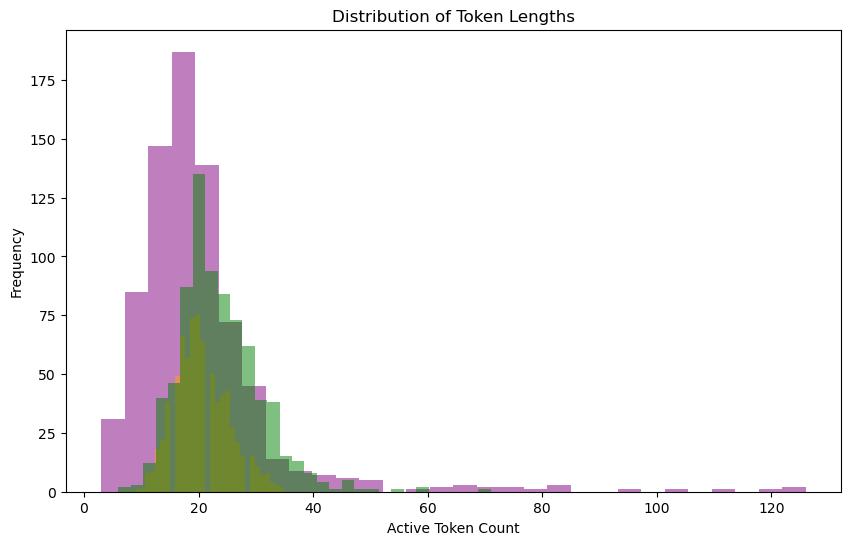

Average token length for Student: 20.43
Percentage truncated for Student: 0.00%
Average token length for ChatGPT 1: 20.56
Percentage truncated for ChatGPT 1: 0.00%
Average token length for ChatGPT 2: 23.59
Percentage truncated for ChatGPT 2: 0.00%


In [11]:
std_tr_lengths = [sum(mask) for mask in std_tr_tokens['attention_mask'].numpy()]
gpt1_tr_lengths = [sum(mask) for mask in gpt1_tr_tokens['attention_mask'].numpy()]
gpt2_tr_lengths = [sum(mask) for mask in gpt2_tr_tokens['attention_mask'].numpy()]

plt.figure(figsize=(10, 6))
plt.hist(std_tr_lengths, bins=30, alpha=0.5, label='Student', color='purple')
plt.hist(gpt1_tr_lengths, bins=30, alpha=0.5, label='ChatGPT 1', color='orange')
plt.hist(gpt2_tr_lengths, bins=30, alpha=0.5, label='ChatGPT 2', color='green')
plt.title('Distribution of Token Lengths')
plt.xlabel('Active Token Count')
plt.ylabel('Frequency')
plt.show()
print(f"Average token length for Student: {np.mean(std_tr_lengths):.2f}")
print(f"Percentage truncated for Student: {sum(l == 128 for l in std_tr_lengths) / len(std_tr_lengths) * 100:.2f}%")
print(f"Average token length for ChatGPT 1: {np.mean(gpt1_tr_lengths):.2f}")
print(f"Percentage truncated for ChatGPT 1: {sum(l == 128 for l in gpt1_tr_lengths) / len(gpt1_tr_lengths) * 100:.2f}%")
print(f"Average token length for ChatGPT 2: {np.mean(gpt2_tr_lengths):.2f}")
print(f"Percentage truncated for ChatGPT 2: {sum(l == 128 for l in gpt2_tr_lengths) / len(gpt2_tr_lengths) * 100:.2f}%")

In [12]:
# Decoding tokens for ensuring correctness
sample_text = gpt1_sen[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Sample Text: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Sample Text: selama libur idul fitri tahun ini, saya merasakan betapa pentingnya teknologi dalam menjaga hubungan dengan keluarga dan teman-teman, terutama di masa pandemi.
Token ID: [2, 776, 7676, 8616, 8109, 262, 92, 30468, 209, 2975, 5108, 5119, 1429, 112, 2079, 1314, 79, 1137, 41, 1614, 30469, 1614, 30468, 1580, 26, 890, 1474, 12815, 30470, 3]
Token dekode: [CLS] selama libur idul fitri tahun ini, saya merasakan betapa pentingnya teknologi dalam menjaga hubungan dengan keluarga dan teman - teman, terutama di masa pandemi. [SEP]


In [13]:
# Save tokenized data
tokenized_data = {
    'student_essay': std_tokens,
    'chatgpt_essay': gpt1_tokens,
    'chatgpt_knowledge': gpt2_tokens
}

# Save input_ids and attention_mask as numpy arrays
tokenized_numpy = {
    'student_essay': {
        'input_ids': std_tokens['input_ids'].numpy(),
        'attention_mask': std_tokens['attention_mask'].numpy()
    },
    'chatgpt_essay': {
        'input_ids': gpt1_tokens ['input_ids'].numpy(),
        'attention_mask': gpt1_tokens ['attention_mask'].numpy()
    },
    'chatgpt_knowledge': {
        'input_ids': gpt2_tokens ['input_ids'].numpy(),
        'attention_mask': gpt2_tokens ['attention_mask'].numpy()
    }
}

os.makedirs("ta_sentence_2", exist_ok=True)

with open('ta_sentence_2/tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

# Build IndoBERT Semantic Similarity Model

In [14]:
# Load IndoBERT model
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Define Bi-Encoder model
def model(bert_model):
    """
    Create a Bi-Encoder model with IndoBERT.
    
    Args:
        bert_model (TFBertModel): Base model of IndoBERT.
        
    Returns:
        tf.keras.Model: Bi-Encoder model.
    """
    # Input layer
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings from IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer for fine-tuning
    dense1 = tf.keras.layers.Dense(128, activation="relu")(bert_output)
    dropout1 = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
    dense3 = tf.keras.layers.Dense(128)(dropout2)
    
    # Output normalization (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3, axis=1)
    
    # Semantic model
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Build model
semantic_model = model(bert_model)

# Show model summary
print("Model Summary:")
semantic_model.summary()


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                        

# Create Contrastive Pairs

In [15]:
def create_contrastive_pairs(student_tokens, chatgpt_tokens_1, chatgpt_tokens_2, max_pairs=None):
    """
    Creates data pairs for contrastive learning with dataset-appropriate quantities.

    Args:
        student_tokens: Tokenized student text
        chatgpt_tokens_1: First set of tokenized ChatGPT text
        chatgpt_tokens_2: Second set of tokenized ChatGPT text
        max_pairs: Maximum number of pairs (optional). If None, uses all possible combinations.

    Returns:
        tuple: Dictionary of anchor, positive, negative pairs and labels, and the total number of pairs.
    """
    # Get dataset sizes
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt_1 = chatgpt_tokens_1['input_ids'].shape[0]
    n_chatgpt_2 = chatgpt_tokens_2['input_ids'].shape[0]
    
    # Calculate maximum possible combinations
    max_student_pairs = (n_student * (n_student - 1)) // 2  # student-student combinations
    max_chatgpt_pairs = (n_chatgpt_1 * (n_chatgpt_1 - 1)) // 2  # chatgpt-chatgpt combinations
    max_negative_pairs = n_student * n_chatgpt_2  # student-chatgpt combinations
    
    # Determine number of pairs to create
    if max_pairs is None:
        # Use minimum number of positive pairs for balance
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Limit negative pairs to balance with positives
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
    else:
        # If max_pairs is specified, use that with equal proportions
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
    
    # Ensure we don't exceed the maximum possible combinations
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)
    
    # Initialize arrays for data pairs
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []
    
    # Generate positive student-student pairs
    if n_pos_student > 0:
        # Create all possible student-student pairs
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Randomly select pairs
        selected_pairs = random.sample(student_pairs, n_pos_student)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (student)
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])
            
            # Positive (another student)
            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])
            
            # Negative (from ChatGPT)
            neg_idx = np.random.choice(n_chatgpt_2)
            negative_input_ids.append(chatgpt_tokens_2['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens_2['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate positive chatgpt-chatgpt pairs
    if n_pos_chatgpt > 0:
        # Create all possible chatgpt-chatgpt pairs
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt_1) for j in range(i+1, n_chatgpt_1)]
        # Randomly select pairs
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (ChatGPT 1)
            anchor_input_ids.append(chatgpt_tokens_1['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens_1['attention_mask'][idx1])
            
            # Positive (ChatGPT 2)
            positive_input_ids.append(chatgpt_tokens_2['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens_2['attention_mask'][idx2])
            
            # Negative (from Student)
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate negative student-chatgpt pairs
    if n_neg_pairs > 0:
        # Create all possible student-chatgpt pairs
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt_2)]
        # Randomly select pairs
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)
        
        for student_idx, chatgpt_idx in selected_pairs:
            # Anchor (Student)
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])
            
            # Negative (ChatGPT)
            negative_input_ids.append(chatgpt_tokens_2['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens_2['attention_mask'][chatgpt_idx])
            
            # Positive (another Student different from anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Ensure there are available indices
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])
                
                # Label (0 for negative pair)
                labels.append(0)
    
    # Count actual pairs created
    actual_pairs = len(labels)
    
    # Convert to tensors and return
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs

In [16]:
# Create contrastive pairs
std_gpt_tr_pairs, total_pairs_tr = create_contrastive_pairs(std_tr_tokens, gpt1_tr_tokens, gpt2_tr_tokens, max_pairs=50000)
std_gpt_va_pairs, total_pairs_va = create_contrastive_pairs(std_va_tokens, gpt1_va_tokens, gpt2_va_tokens, max_pairs=50000)

# Show the number of pairs created
print(f"Total contrastive pairs (training) created: {total_pairs_tr}")
print(f"- Positive pairs student-student: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Positive pairs chatgpt-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Negative pairs student-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 0)}")


Total contrastive pairs (training) created: 50000
- Positive pairs student-student: 12500
- Positive pairs chatgpt-chatgpt: 12500
- Negative pairs student-chatgpt: 25000


# Build Triplet Model

In [17]:
# Model for training with triplet loss
def triplet_model(semantic_model):
    """
    Build a model for training with triplet loss.
    
    Args:
        semantic_model: The semantic similarity model to be trained.
        
    Returns:
         tf.keras.Model: Model for training with triplet loss.
    """
    # Input for anchor, positive, and negative
    anchor_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="anchor_input_ids")
    anchor_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="anchor_attention_mask")
    
    positive_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="positive_input_ids")
    positive_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="positive_attention_mask")
    
    negative_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="negative_input_ids")
    negative_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="negative_attention_mask")
    
    # Embedding for anchor, positive, and negative
    anchor_embedding = semantic_model([anchor_input_ids, anchor_attention_mask])
    positive_embedding = semantic_model([positive_input_ids, positive_attention_mask])
    negative_embedding = semantic_model([negative_input_ids, negative_attention_mask])
    
    # measure cosine similarity
    pos_similarity = tf.reduce_sum(anchor_embedding * positive_embedding, axis=1)
    neg_similarity = tf.reduce_sum(anchor_embedding * negative_embedding, axis=1)
    
    # Model output is the similarity score
    output = tf.stack([pos_similarity, neg_similarity], axis=1)
    
    return tf.keras.Model(
        inputs=[
            anchor_input_ids, anchor_attention_mask,
            positive_input_ids, positive_attention_mask,
            negative_input_ids, negative_attention_mask
        ],
        outputs=output
    )

# Triplet Loss Function

In [18]:
# Triplet loss function
def triplet_loss(y_true, y_pred):
    """
    Triplet loss: tunes the network such that
the distance between a and p is smaller than the
distance between a and n.
    
    Args:
        y_true: not used triplet loss.
        y_pred: stack of [positive_similarity, negative_similarity].
        
    Returns:
        tf.Tensor: loss value.
    """
    pos_sim = y_pred[:, 0]
    neg_sim = y_pred[:, 1]
    margin = 0.5
    
    # Triplet loss: max(0, margin - (pos_sim - neg_sim))
    loss = tf.maximum(0., margin - (pos_sim - neg_sim))
    return tf.reduce_mean(loss)

# Train IndoBERT Semantic Similarity Model

In [19]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 SUPER, compute capability 7.5


In [20]:
# Build triplet model for student vs ChatGPT essay
build_triplet = triplet_model(semantic_model)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

build_triplet.compile(
    optimizer=optimizer,
    loss=triplet_loss
)

# Training model Student_ChatGPT
print("Training model...")
history = build_triplet.fit(
    x=[
        std_gpt_tr_pairs['anchor']['input_ids'],
        std_gpt_tr_pairs['anchor']['attention_mask'],
        std_gpt_tr_pairs['positive']['input_ids'],
        std_gpt_tr_pairs['positive']['attention_mask'],
        std_gpt_tr_pairs['negative']['input_ids'],
        std_gpt_tr_pairs['negative']['attention_mask']
    ],
    y=std_gpt_tr_pairs['labels'], 
    epochs=3,
    batch_size=16,
    validation_data=(
    [
        std_gpt_va_pairs['anchor']['input_ids'],
        std_gpt_va_pairs['anchor']['attention_mask'],
        std_gpt_va_pairs['positive']['input_ids'],
        std_gpt_va_pairs['positive']['attention_mask'],
        std_gpt_va_pairs['negative']['input_ids'],
        std_gpt_va_pairs['negative']['attention_mask']
    ],
    std_gpt_va_pairs['labels']
    )
)

Training model...
Epoch 1/3


I0000 00:00:1749789399.426560   68136 service.cc:152] XLA service 0x7f1c2c08f4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749789399.426595   68136 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-06-13 11:36:39.438025: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749789399.504981   68138 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/3125 [..............................] - ETA: 15:47:40 - loss: 0.4870

I0000 00:00:1749789399.714398   68136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 [==============================] - 1652s 523ms/step - loss: 0.1860 - val_loss: 0.1033
Epoch 2/3
3125/3125 [==============================] - 1645s 527ms/step - loss: 0.1051 - val_loss: 0.1037
Epoch 3/3
3125/3125 [==============================] - 1649s 528ms/step - loss: 0.0740 - val_loss: 0.0991


# Training History

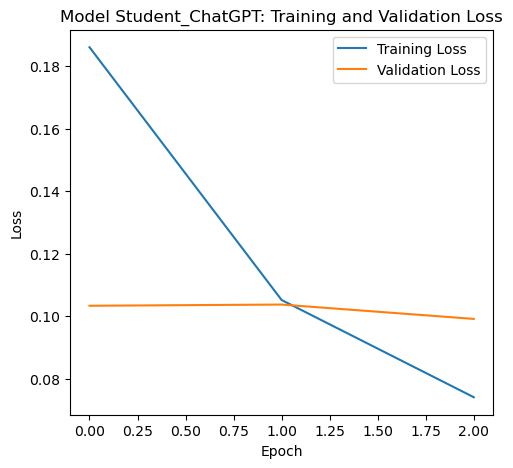

In [21]:
# Plot training history untuk model Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Student_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate Embeddings Function

In [22]:
def gen_emb(tokens, model, batch_size=32):
    """
    Generate embeddings using IndoBERT in batches.
    
    Args:
        tokens: Token from text.
        model: IndoBERT Semantic Similarity.
        batch_size: Number of samples per batch.
        
    Returns:
        np.ndarray: Embeddings.
    """
    embeddings = []
    
    num_batches = len(tokens['input_ids']) // batch_size + (len(tokens['input_ids']) % batch_size > 0)
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(tokens['input_ids']))

        batch_input_ids = tokens['input_ids'][start_idx:end_idx]
        batch_attention_mask = tokens['attention_mask'][start_idx:end_idx]
        
        batch_embeddings = model([batch_input_ids, batch_attention_mask])
        
        embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

# Cosine Similarity Function

In [23]:
def cos_sim(embedding1, embedding2):
    """
    Calculate similarity score using standard cosine similarity.
    
    Args:
        embedding1: First embedding (input text)
        embedding2: Second embedding (reference)
        
    Returns:
        float: Average cosine similarity score
    """
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])

    avg_similarity = tf.reduce_mean(similarities).numpy()
    return avg_similarity


# Generate Embeddings (All Text)

In [24]:
# Generate embeddings for all text
print("Generating embeddings for Student Essay (all text)...")
std_emb = gen_emb(std_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT Essay (all text)...")
gpt1_emb = gen_emb(gpt1_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT Knowledge (all text)...")
gpt2_emb = gen_emb(gpt2_tokens, semantic_model, batch_size=32)


Generating embeddings for Student Essay (all text)...
Generating embeddings for ChatGPT Essay (all text)...
Generating embeddings for ChatGPT Knowledge (all text)...


# Measure Similarity Score (All Text)

In [25]:
std_std_sim_scores = []
std_gpt1_sim_scores = []
std_gpt2_sim_scores = []

for emb in std_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt1_emb)
    std_gpt1_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt2_emb)
    std_gpt2_sim_scores.append(avg_similarity)

gpt1_std_sim_scores = []
gpt1_gpt1_sim_scores = []
gpt1_gpt2_sim_scores = []

for emb in gpt1_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt1_std_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt1_emb)
    gpt1_gpt1_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt2_emb)
    gpt1_gpt2_sim_scores.append(avg_similarity)

std_sim_scores = np.array([
    std_std_sim_scores, 
    std_gpt1_sim_scores,
    std_gpt2_sim_scores
])

gpt_sim_scores = np.array([
    gpt1_std_sim_scores, 
    gpt1_gpt1_sim_scores,
    gpt1_gpt2_sim_scores
])

# Visualization of Similarity Score (All Text)

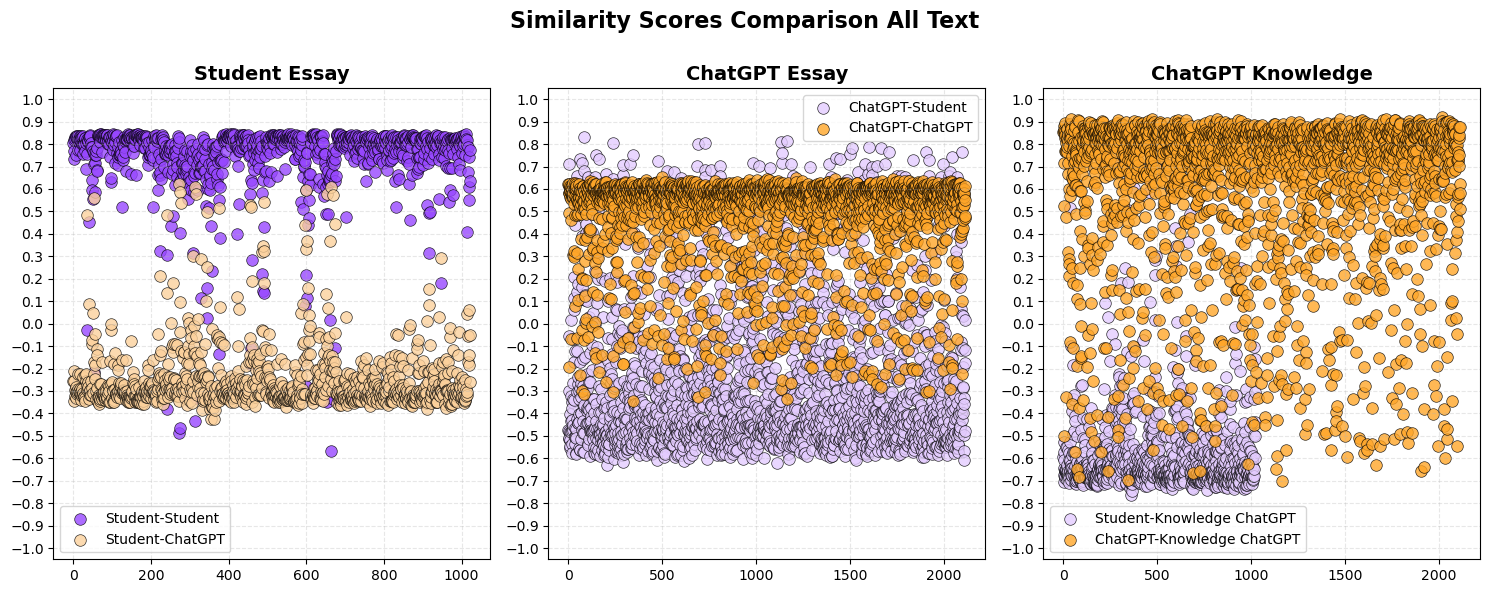

In [26]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student Essay
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_sim_scores)), std_std_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt1_sim_scores)), std_gpt1_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT Essay
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt1_std_sim_scores)), gpt1_std_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt1_gpt1_sim_scores)), gpt1_gpt1_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(range(len(std_gpt2_sim_scores)), std_gpt2_sim_scores, 
            label='Student-Knowledge ChatGPT', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt1_gpt2_sim_scores)), gpt1_gpt2_sim_scores, 
            label='ChatGPT-Knowledge ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Knowledge', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison All Text', fontsize=16, fontweight='bold', y=0.98, ha='center')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

os.makedirs('ta_sentence_2/images', exist_ok=True)
plt.savefig('ta_sentence_2/images/similarity_scores_comparison(all).png', dpi=300, bbox_inches='tight')

plt.show()

# Generate Embeddings (Test Set)

In [27]:
# Generate embeddings for data test
print("Generating embeddings for Student (test set)...")
std_te_emb = gen_emb(std_te_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (test set)...")
gpt1_te_emb = gen_emb(gpt1_te_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT Knowledge (test set)...")
gpt2_te_emb = gen_emb(gpt2_te_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (test set)...
Generating embeddings for ChatGPT (test set)...
Generating embeddings for ChatGPT Knowledge (test set)...


# Measure Similarity Score (Test Set)

In [28]:
std_std_te_sim_scores = []
std_gpt1_te_sim_scores = []
std_gpt2_te_sim_scores = []
for emb in std_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt1_emb)
    std_gpt1_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt2_emb)
    std_gpt2_te_sim_scores.append(avg_similarity)

gpt1_std_te_sim_scores = []
gpt1_gpt1_te_sim_scores = []
gpt1_gpt2_te_sim_scores = []

for emb in gpt1_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt1_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt1_emb)
    gpt1_gpt1_te_sim_scores.append(avg_similarity)
    
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt2_emb)
    gpt1_gpt2_te_sim_scores.append(avg_similarity)


std_te_sim_scores = np.array([
    std_std_te_sim_scores, 
    std_gpt1_te_sim_scores,
    std_gpt2_te_sim_scores
])

gpt_te_sim_scores = np.array([
    gpt1_std_te_sim_scores, 
    gpt1_gpt1_te_sim_scores,
    gpt1_gpt2_te_sim_scores
])

# Similarity Text Breakdown (Test Set)

In [29]:
test_pairs = []
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.width', 1000)        
pd.set_option('display.max_rows', None)      

for i, student_text in enumerate(std_sen):
    if i >= len(std_te_emb):
        continue
        
    student_embedding = tf.expand_dims(std_te_emb[i], 0)

    for j in range(len(gpt1_sen)):
        if j >= len(gpt1_te_emb):
            continue

        chatgpt1_embedding = tf.expand_dims(gpt1_te_emb[j], 0)
        similarity = cos_sim(student_embedding, chatgpt1_embedding)
        
        test_pairs.append({
            'student_idx': i,
            'chatgpt_idx': j,
            'student_text': student_text,
            'chatgpt_text': gpt1_sen[j],
            'similarity_score': similarity
        })

sorted_pairs = sorted(test_pairs, key=lambda x: x['similarity_score'], reverse=True)

result_v1 = sorted_pairs[:5]

df_v1 = pd.DataFrame(result_v1)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v1.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 1: Standard ===")
display(df_v1)

used_student_indices_v2 = set()
used_chatgpt_indices_v2 = set()
result_v2 = []

for pair in sorted_pairs:
    if (pair['student_idx'] in used_student_indices_v2 or 
        pair['chatgpt_idx'] in used_chatgpt_indices_v2):
        continue
    result_v2.append(pair)
    used_student_indices_v2.add(pair['student_idx'])
    used_chatgpt_indices_v2.add(pair['chatgpt_idx'])
    if len(result_v2) >= 5:
        break

df_v2 = pd.DataFrame(result_v2)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v2.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 2: Unique ===")
display(df_v2)

=== 1: Standard ===


,Student Essay,ChatGPT Essay,Similarity Score
0,"lebaran hari kelima, ketupat dan opor masih ada sisa.","pengalaman ini membuat saya menyadari betapa pentingnya teknologi dalam mendukung berbagai aktivitas, bahkan dalam situasi liburan sekalipun.",0.979948
1,berikut kegiatan saya dari tanggal pada bulan ramadhan....,"pengalaman ini membuat saya menyadari betapa pentingnya teknologi dalam mendukung berbagai aktivitas, bahkan dalam situasi liburan sekalipun.",0.973325
2,saya juga menggunakan internet untuk mencari resep masakan idul fitri yang lezat dan mudah dibuat.,"secara keseluruhan, teknologi telah menjadi aset berharga dalam membuat libur idul fitri kali ini tetap meriah dan bermakna, meski dengan segala keterbatasan yang ada.",0.972736
3,"ketiga saya juga tidak luput dari yang namanya handphone, saya memainkan banyak permainan yang ad di handphone, contohnya free fire, roblox, dll.","pengalaman ini membuat saya menyadari betapa pentingnya teknologi dalam mendukung berbagai aktivitas, bahkan dalam situasi liburan sekalipun.",0.971477
4,"selama idul fitri, saya merasakan kebahagiaan dan kegembiraan yang luar biasa.","pengalaman ini membuat saya menyadari betapa pentingnya teknologi dalam mendukung berbagai aktivitas, bahkan dalam situasi liburan sekalipun.",0.970449


=== 2: Unique ===


,Student Essay,ChatGPT Essay,Similarity Score
0,"lebaran hari kelima, ketupat dan opor masih ada sisa.","pengalaman ini membuat saya menyadari betapa pentingnya teknologi dalam mendukung berbagai aktivitas, bahkan dalam situasi liburan sekalipun.",0.979948
1,saya juga menggunakan internet untuk mencari resep masakan idul fitri yang lezat dan mudah dibuat.,"secara keseluruhan, teknologi telah menjadi aset berharga dalam membuat libur idul fitri kali ini tetap meriah dan bermakna, meski dengan segala keterbatasan yang ada.",0.972736
2,pengalaman saya saat libur idul fitri.,teknologi memungkinkan saya untuk berbagi kebahagiaan dan harapan baik meskipun jarak memisahkan kita.,0.963657
3,pada saat bulan ramadhan dari tanggal 28 februari sampai tanggal 30 2025 saya awali dengan sholat shubuh berjamaah.,"selama liburan, saya juga memanfaatkan berbagai aplikasi hiburan seperti streaming musik dan film untuk mengisi waktu luang.",0.963512
4,saya akan menceritakan kegiatan saya selama bulan ramadhan dalam menggunakan teknologi.,"tidak hanya untuk berkomunikasi, saya juga memanfaatkan teknologi untuk menambah wawasan selama liburan.",0.962323


# Visualization of Similarity Score (Test Set)

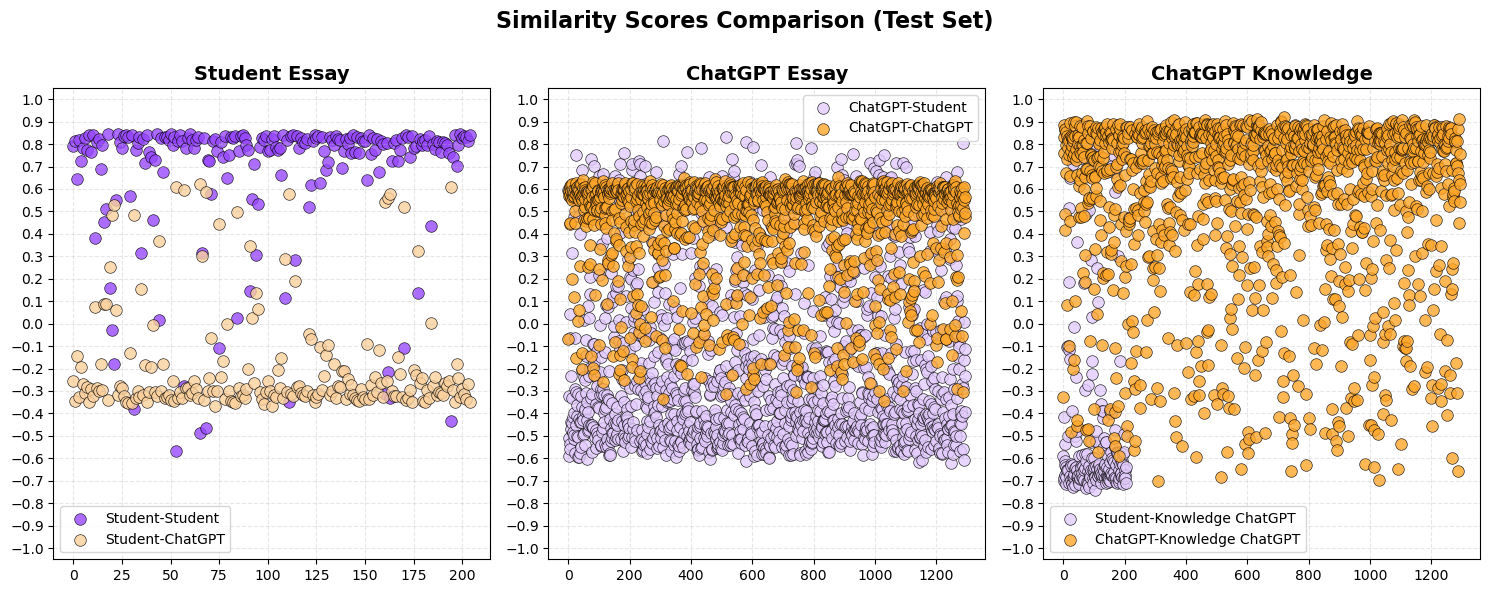

In [30]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_te_sim_scores)), std_std_te_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt1_te_sim_scores)), std_gpt1_te_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt1_std_te_sim_scores)), gpt1_std_te_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt1_gpt1_te_sim_scores)), gpt1_gpt1_te_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(range(len(std_gpt2_te_sim_scores)), std_gpt2_te_sim_scores, 
            label='Student-Knowledge ChatGPT', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt1_gpt2_te_sim_scores)), gpt1_gpt2_te_sim_scores, 
            label='ChatGPT-Knowledge ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Knowledge', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison (Test Set)', fontsize=16, fontweight='bold', y=0.98, ha='center')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

plt.savefig('ta_sentence_2/images/similarity_scores_comparison(test).png', dpi=300, bbox_inches='tight')

plt.show()

# Generate Embeddings (Training & Validation Sets)

In [31]:
# Generate embeddings for training and validation sets
print("Generating embeddings for Student (training set)...")
std_tr_emb = gen_emb(std_tr_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (training set)...")
gpt1_tr_emb = gen_emb(gpt1_tr_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT knowledge (training set)...")
gpt2_tr_emb = gen_emb(gpt2_tr_tokens, semantic_model, batch_size=32)

print("Generating embeddings for Student (validation set)...")
std_va_emb = gen_emb(std_va_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (validation set)...")
gpt1_va_emb = gen_emb(gpt1_va_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT knowledge (validation set)...")
gpt2_va_emb = gen_emb(gpt2_va_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (training set)...
Generating embeddings for ChatGPT (training set)...
Generating embeddings for ChatGPT knowledge (training set)...
Generating embeddings for Student (validation set)...
Generating embeddings for ChatGPT (validation set)...
Generating embeddings for ChatGPT knowledge (validation set)...


# Measure Similarity Score (Training & Validation Sets)

In [32]:
# Training set
std_std_tr_sim_scores = []
std_gpt1_tr_sim_scores = []
std_gpt2_tr_sim_scores = []
for emb in std_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt1_emb)
    std_gpt1_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt2_emb)
    std_gpt2_tr_sim_scores.append(avg_similarity)

gpt1_std_tr_sim_scores = []
gpt1_gpt1_tr_sim_scores = []
gpt1_gpt2_tr_sim_scores = []

for emb in gpt1_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt1_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt1_emb)
    gpt1_gpt1_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt2_emb)
    gpt1_gpt2_tr_sim_scores.append(avg_similarity)

std_tr_sim_scores = np.array([
    std_std_tr_sim_scores, 
    std_gpt1_tr_sim_scores,
    std_gpt2_tr_sim_scores
])

gpt_tr_sim_scores = np.array([
    gpt1_std_tr_sim_scores, 
    gpt1_gpt1_tr_sim_scores,
    gpt1_gpt2_tr_sim_scores
])

# Validation set
std_std_va_sim_scores = []
std_gpt1_va_sim_scores = []
std_gpt2_va_sim_scores = []
for emb in std_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt1_emb)
    std_gpt1_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt2_emb)
    std_gpt2_va_sim_scores.append(avg_similarity)

gpt1_std_va_sim_scores = []
gpt1_gpt1_va_sim_scores = []
gpt1_gpt2_va_sim_scores = []
for emb in gpt1_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt1_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt1_emb)
    gpt1_gpt1_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt2_emb)
    gpt1_gpt2_va_sim_scores.append(avg_similarity)

std_va_sim_scores = np.array([
    std_std_va_sim_scores, 
    std_gpt1_va_sim_scores,
    std_gpt2_va_sim_scores
])

gpt_va_sim_scores = np.array([
    gpt1_std_va_sim_scores, 
    gpt1_gpt1_va_sim_scores,
    gpt1_gpt2_va_sim_scores
])



# Define Linguistic Features

In [33]:
def linguistic_features(text):
    """
    Features extraction from text:
    1.	Lexical Diversity
    2.	Total words in the essay
    3.	Total unique words*
    4.	Modals
    5.	Stopwords ratio*

    
    Args:
        text (str): Input text.
        
    Returns:
        dict: Linguistic features.
    """
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    word_count = len(words)
    unique_count = len(set(words))
    
    ld = (unique_count / word_count * 100) if word_count > 0 else 0
    
    # Load modals from corpus file
    modals = set()
    if os.path.exists('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv'):
        with open('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv', 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split('\t')
                    if len(parts) >= 2 and parts[1] == 'MD':
                        modals.add(parts[0].lower())
    
    # Count modals in text
    modal_count = sum(1 for word in words if word.lower() in modals)
    
    # Load stopwords from file
    stopwords = set()
    if os.path.exists('corpus/stopwords.txt'):
        with open('corpus/stopwords.txt', 'r', encoding='utf-8') as f:
            for line in f:
                stopwords.add(line.strip())
    
    # Calculate stopword ratio
    stopword_count = sum(1 for word in words if word.lower() in stopwords)
    stopword_ratio = (stopword_count / word_count * 100) if word_count > 0 else 0

    return {
        'lexical_diversity': ld,
        'total_words': word_count,
        'total_unique_words': unique_count,
        'modals': modal_count,
        'stopwords_ratio': stopword_ratio,
    }

# Features Extraction (All Text)

In [34]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student...")
std_features = [linguistic_features(text) for text in std_sen]

print("Features extraction for ChatGPT...")
gpt_features = [linguistic_features(text) for text in gpt1_sen]


# convert
std_features_df = pd.DataFrame(std_features)
gpt_features_df = pd.DataFrame(gpt_features)


# Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features:")
display(std_features_df.head())

print("\nChatGPT Linguistic Features:")
display(gpt_features_df.head())

Features extraction for Student...
Features extraction for ChatGPT...

Student Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio
0,66.176471,68,45,0,50.000000
1,83.720930,43,36,0,53.488372
2,83.333333,30,25,0,56.666667
3,54.651163,86,47,2,54.651163
4,82.926829,41,34,0,31.707317



ChatGPT Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio
0,95.652174,23,22,0,47.826087
1,100.000000,16,16,0,56.250000
2,100.000000,14,14,1,64.285714
3,100.000000,20,20,1,45.000000
4,100.000000,11,11,0,45.454545


# Normalize Linguistic Features (All Text)

In [35]:
# Combine features into a single DataFrame
all_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Separate normalized features back into student and ChatGPT
n_student = len(std_features_df)
n_chatgpt = len(gpt_features_df)

std_features_norm = normalized_features[:n_student]
gpt_features_norm = normalized_features[n_student:n_student + n_chatgpt]

print("Student features after normalization:")
print(std_features_norm[:5])

print("ChatGPT features after normalization:")
print(gpt_features_norm[:5])

# Save scaler for later inference
try:
    with open('ta_sentence_2/scaler_linguistic.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Scaler saved successfully.")
except Exception as e:
    print(f"Error saving scaler: {e}")

Student features after normalization:
[[-4.21572223e+00  6.60951475e+00  5.26171724e+00 -6.73536488e-01
   6.30612073e-03]
 [-1.68322982e+00  3.42261965e+00  3.67537829e+00 -6.73536488e-01
   2.91933784e-01]
 [-1.73917832e+00  1.76543420e+00  1.73651957e+00 -6.73536488e-01
   5.52172322e-01]
 [-5.87936735e+00  8.90407923e+00  5.61423701e+00  2.21199688e+00
   3.87143005e-01]
 [-1.79785601e+00  3.16766804e+00  3.32285852e+00 -6.73536488e-01
  -1.49149748e+00]]
ChatGPT features after normalization:
[[ 0.03901098  0.87310357  1.20773992 -0.67353649 -0.17169373]
 [ 0.6666072  -0.01922706  0.15018062 -0.67353649  0.51805568]
 [ 0.6666072  -0.27417867 -0.20233915  0.7692302   1.17601941]
 [ 0.6666072   0.49067616  0.85522015  0.7692302  -0.40309353]
 [ 0.6666072  -0.65660608 -0.7311188  -0.67353649 -0.36587538]]
Scaler saved successfully.


In [36]:
# Add labels to features
std_features_df['label'] = 'Student Essay'
gpt_features_df['label'] = 'ChatGPT Essay'

# Combine datasets
combined_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Visualize Linguistic Features (All Texts)

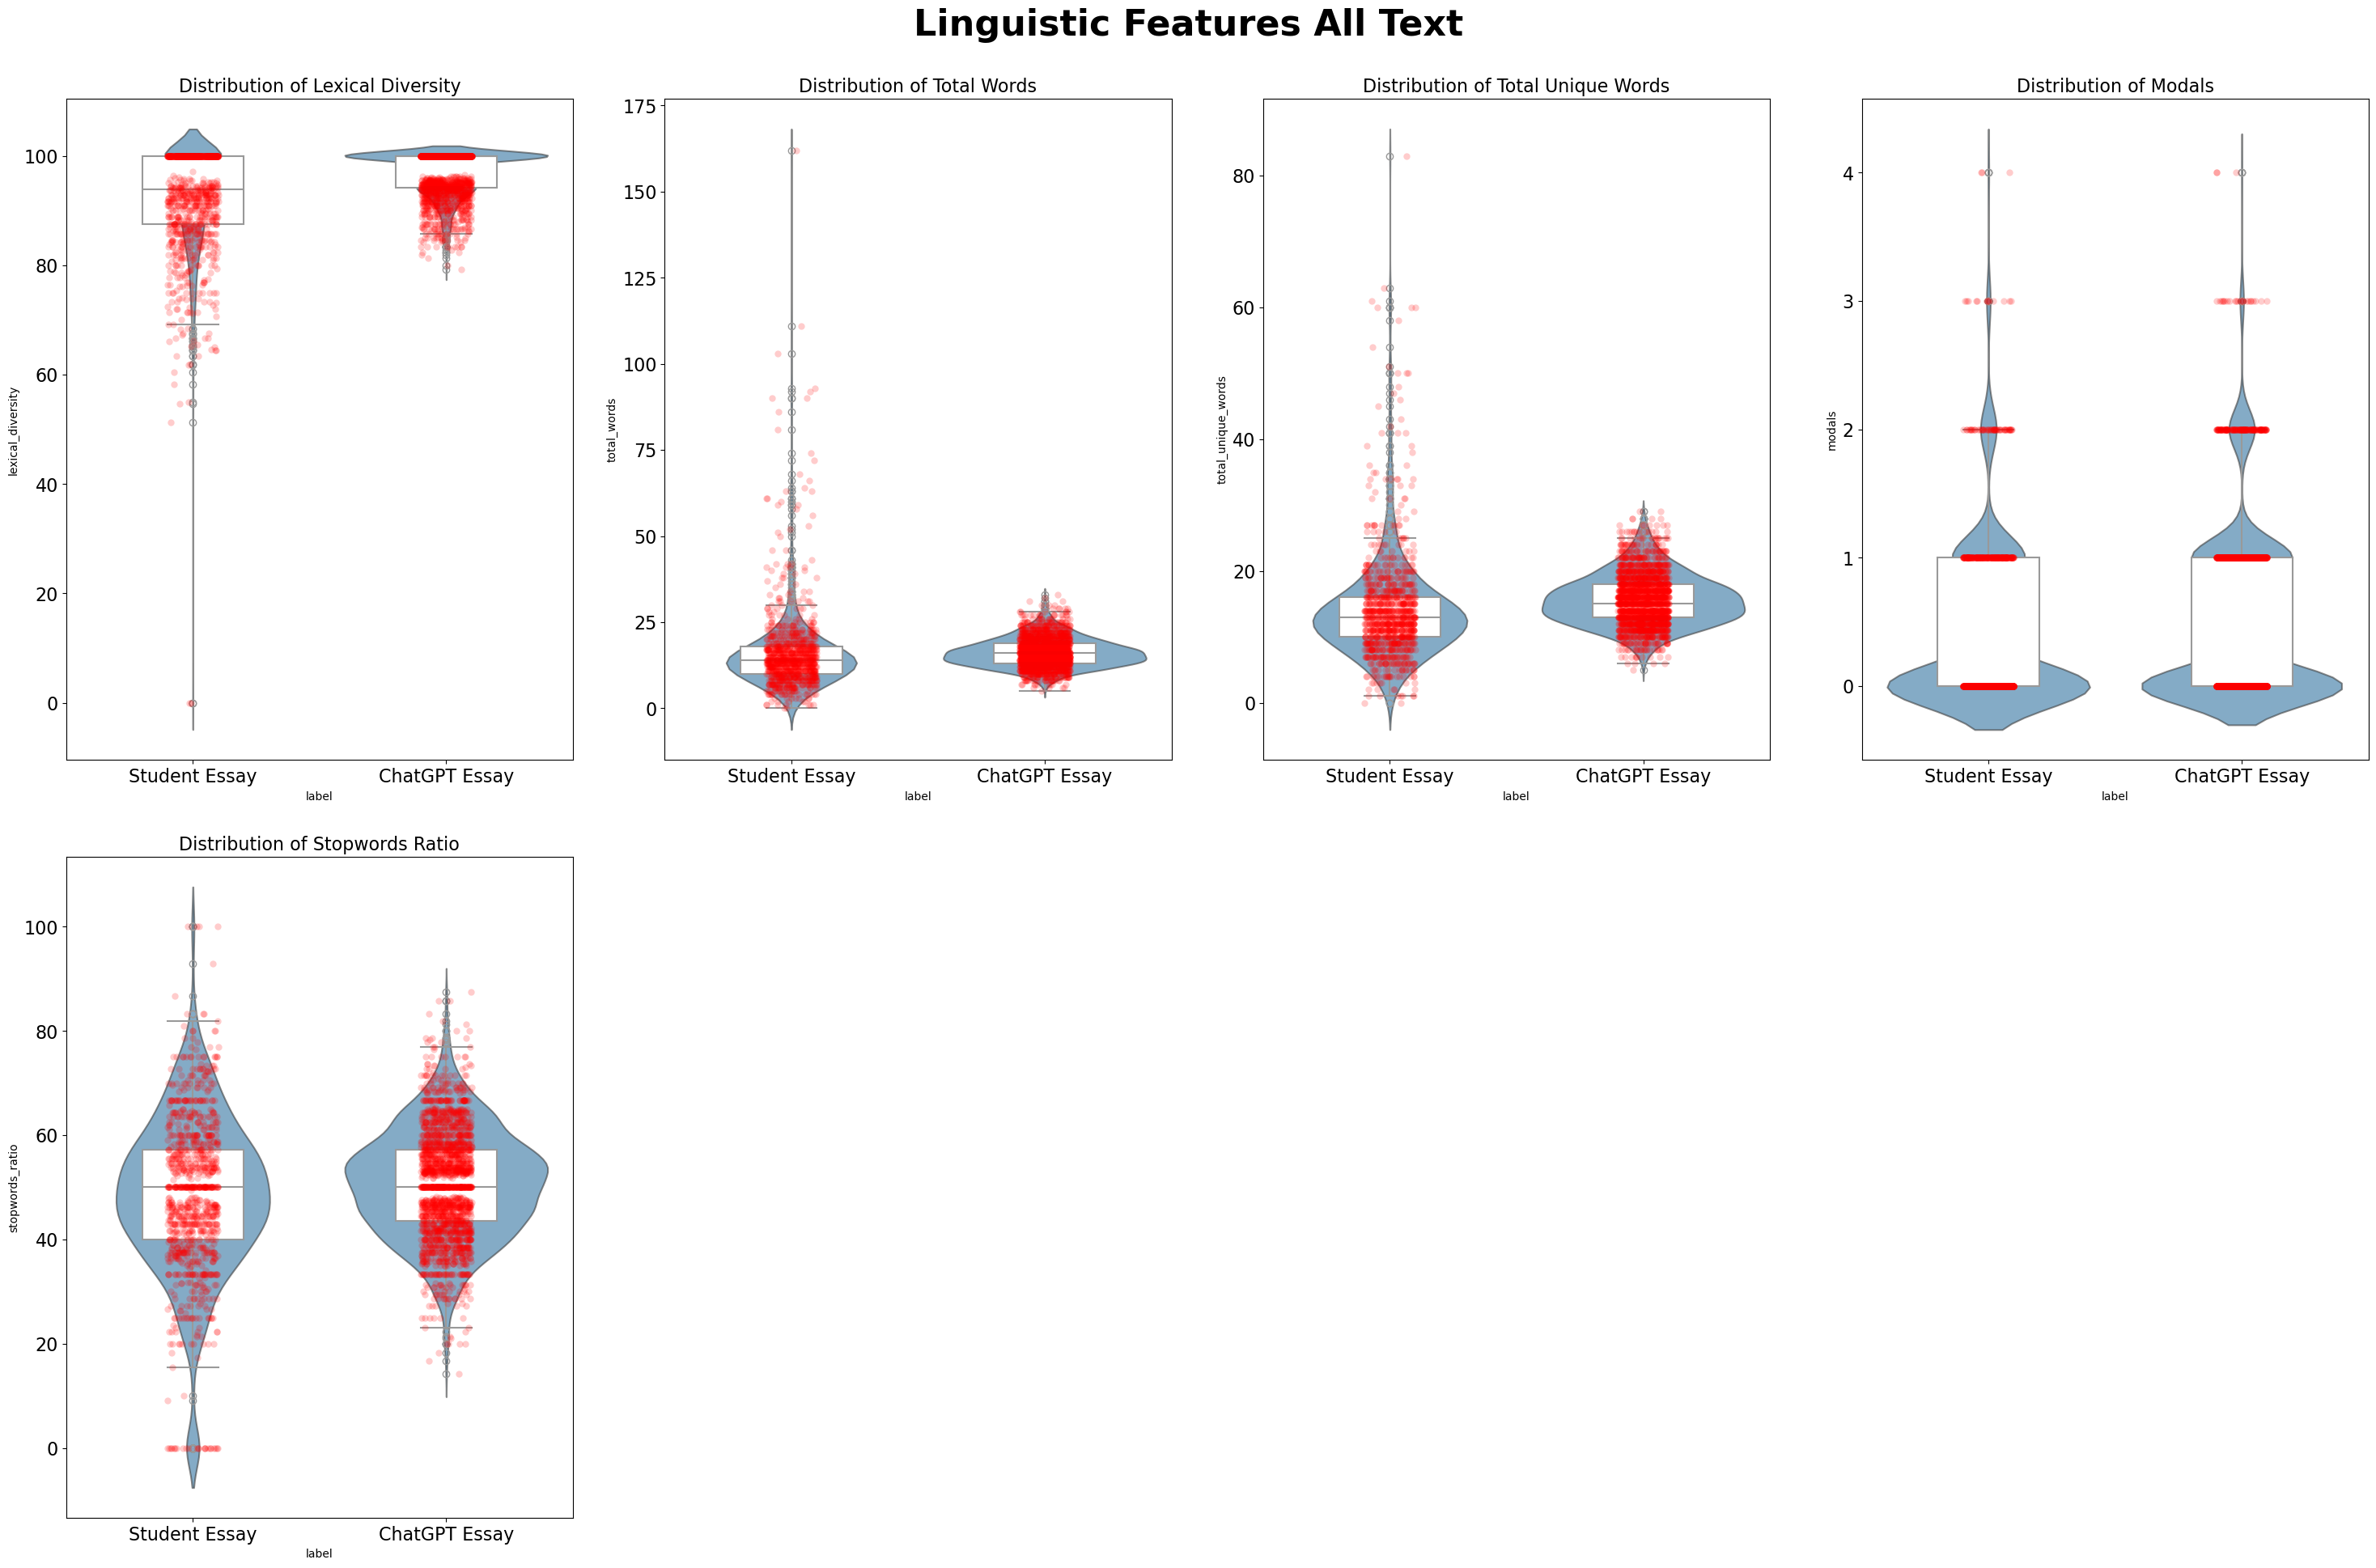

In [37]:
plt.figure(figsize=(30, 20))
for i, feature in enumerate([
    'lexical_diversity',
    'total_words',
    'total_unique_words',
    'modals',
    'stopwords_ratio',
]):
    plt.subplot(2, 4, i+1)
    sns.violinplot(x='label', y=feature, data=combined_features, inner=None, alpha=0.6, linewidth=1.5)
    sns.boxplot(x='label', y=feature, data=combined_features, width=0.4, 
                saturation=1, showfliers=True, color='white', linewidth=1.5)
    sns.stripplot(x='label', y=feature, data=combined_features, color='red', alpha=0.2, size=6, jitter=True, dodge=True)
    plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

plt.suptitle('Linguistic Features All Text', fontsize=32, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.0)

plt.savefig('ta_sentence_2/images/linguistic_features_comparison(all).png', dpi=300, bbox_inches='tight')

plt.show()


# Feature Extraction (Training, Validation, & Test Sets)

In [38]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student (training set)...")
std_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (training set)...")
gpt_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (validation set)...")
std_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (validation set)...")
gpt_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (test set)...")
std_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (test set)...")
gpt_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 1]['text'].tolist()]

# convert
std_tr_features_df = pd.DataFrame(std_tr_features)
gpt_tr_features_df = pd.DataFrame(gpt_tr_features)

std_va_features_df = pd.DataFrame(std_va_features)
gpt_va_features_df = pd.DataFrame(gpt_va_features)

std_te_features_df = pd.DataFrame(std_te_features)
gpt_te_features_df = pd.DataFrame(gpt_te_features)

#Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features (Test Set):")
display(std_te_features_df.head())

print("\nChatGPT Linguistic Features (Test Set):")
display(gpt_te_features_df.head())

Features extraction for Student (training set)...
Features extraction for ChatGPT (training set)...
Features extraction for Student (validation set)...
Features extraction for ChatGPT (validation set)...
Features extraction for Student (test set)...
Features extraction for ChatGPT (test set)...

Student Linguistic Features (Test Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio
0,94.444444,18,17,0,50.000000
1,100.000000,8,8,0,50.000000
2,88.888889,9,8,0,44.444444
3,100.000000,8,8,0,37.500000
4,100.000000,17,17,0,47.058824



ChatGPT Linguistic Features (Test Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio
0,90.000000,20,18,0,30.000000
1,92.857143,28,26,0,53.571429
2,100.000000,16,16,1,56.250000
3,100.000000,22,22,2,68.181818
4,100.000000,14,14,0,50.000000


In [39]:
std_tr_features_df.shape, gpt_tr_features_df.shape, std_va_features_df.shape, gpt_va_features_df.shape, std_te_features_df.shape, gpt_te_features_df.shape

((767, 5), (767, 5), (51, 5), (51, 5), (205, 5), (1295, 5))

# Normalize Linguistic Features (Training, Validation, & Test Sets)

In [40]:
# Combine features into a single DataFrame
all_tr_features = pd.concat([std_tr_features_df, gpt_tr_features_df], axis=0)
all_va_features = pd.concat([std_va_features_df, gpt_va_features_df], axis=0)
all_te_features = pd.concat([std_te_features_df, gpt_te_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_tr_features = scaler.fit_transform(all_tr_features)
normalized_va_features = scaler.fit_transform(all_va_features)
normalized_te_features = scaler.fit_transform(all_te_features)

# Separate normalized features back into student and ChatGPT
n_student_tr = len(std_tr_features_df)
n_chatgpt_tr = len(gpt_tr_features_df)

n_student_va = len(std_va_features_df)
n_chatgpt_va = len(gpt_va_features_df)

n_student_te = len(std_te_features_df)
n_chatgpt_te = len(gpt_te_features_df)

std_tr_features_norm = normalized_tr_features[:n_student_tr]
gpt_tr_features_norm = normalized_tr_features[n_student_tr:n_student_tr + n_chatgpt_tr]

std_va_features_norm = normalized_va_features[:n_student_va]
gpt_va_features_norm = normalized_va_features[n_student_va:n_student_va + n_chatgpt_va]

std_te_features_norm = normalized_te_features[:n_student_te]
gpt_te_features_norm = normalized_te_features[n_student_te:n_student_te + n_chatgpt_te]

print("Student features after normalization (training):")
print(std_tr_features_norm[:5])

print("ChatGPT features after normalization (training):")
print(gpt_tr_features_norm[:5])

Student features after normalization (training):
[[-1.11867672 -0.22106262 -0.44059855 -0.63766835  0.02919193]
 [ 0.18912594  1.17349552  1.66494096  0.77385149  1.44749351]
 [-0.72098234  1.28970869  1.50297638  0.77385149  0.4389235 ]
 [ 0.67094797 -0.8021285  -0.92649229 -0.63766835  1.25838663]
 [ 0.67094797 -1.03455486 -1.25042144 -0.63766835 -0.49760579]]
ChatGPT features after normalization (training):
[[ 0.67094797  0.36000327  0.69315349  0.77385149  0.22327531]
 [ 0.67094797  0.01136374  0.20725976 -0.63766835 -0.89270409]
 [-0.06595631  0.12757692  0.20725976 -0.63766835 -1.48922505]
 [ 0.01161256  0.36000327  0.53118891 -0.63766835 -0.55305819]
 [-0.11201283  0.01136374  0.04529518 -0.63766835  0.49013995]]


# Visualize Linguistic Features (Data Test)

In [41]:
# Add labels to features
std_tr_features_df['label'] = 'Student Essay'
gpt_tr_features_df['label'] = 'ChatGPT Essay'

# Combine datasets
combined_tr_features = pd.concat([std_tr_features_df, gpt_tr_features_df], axis=0)

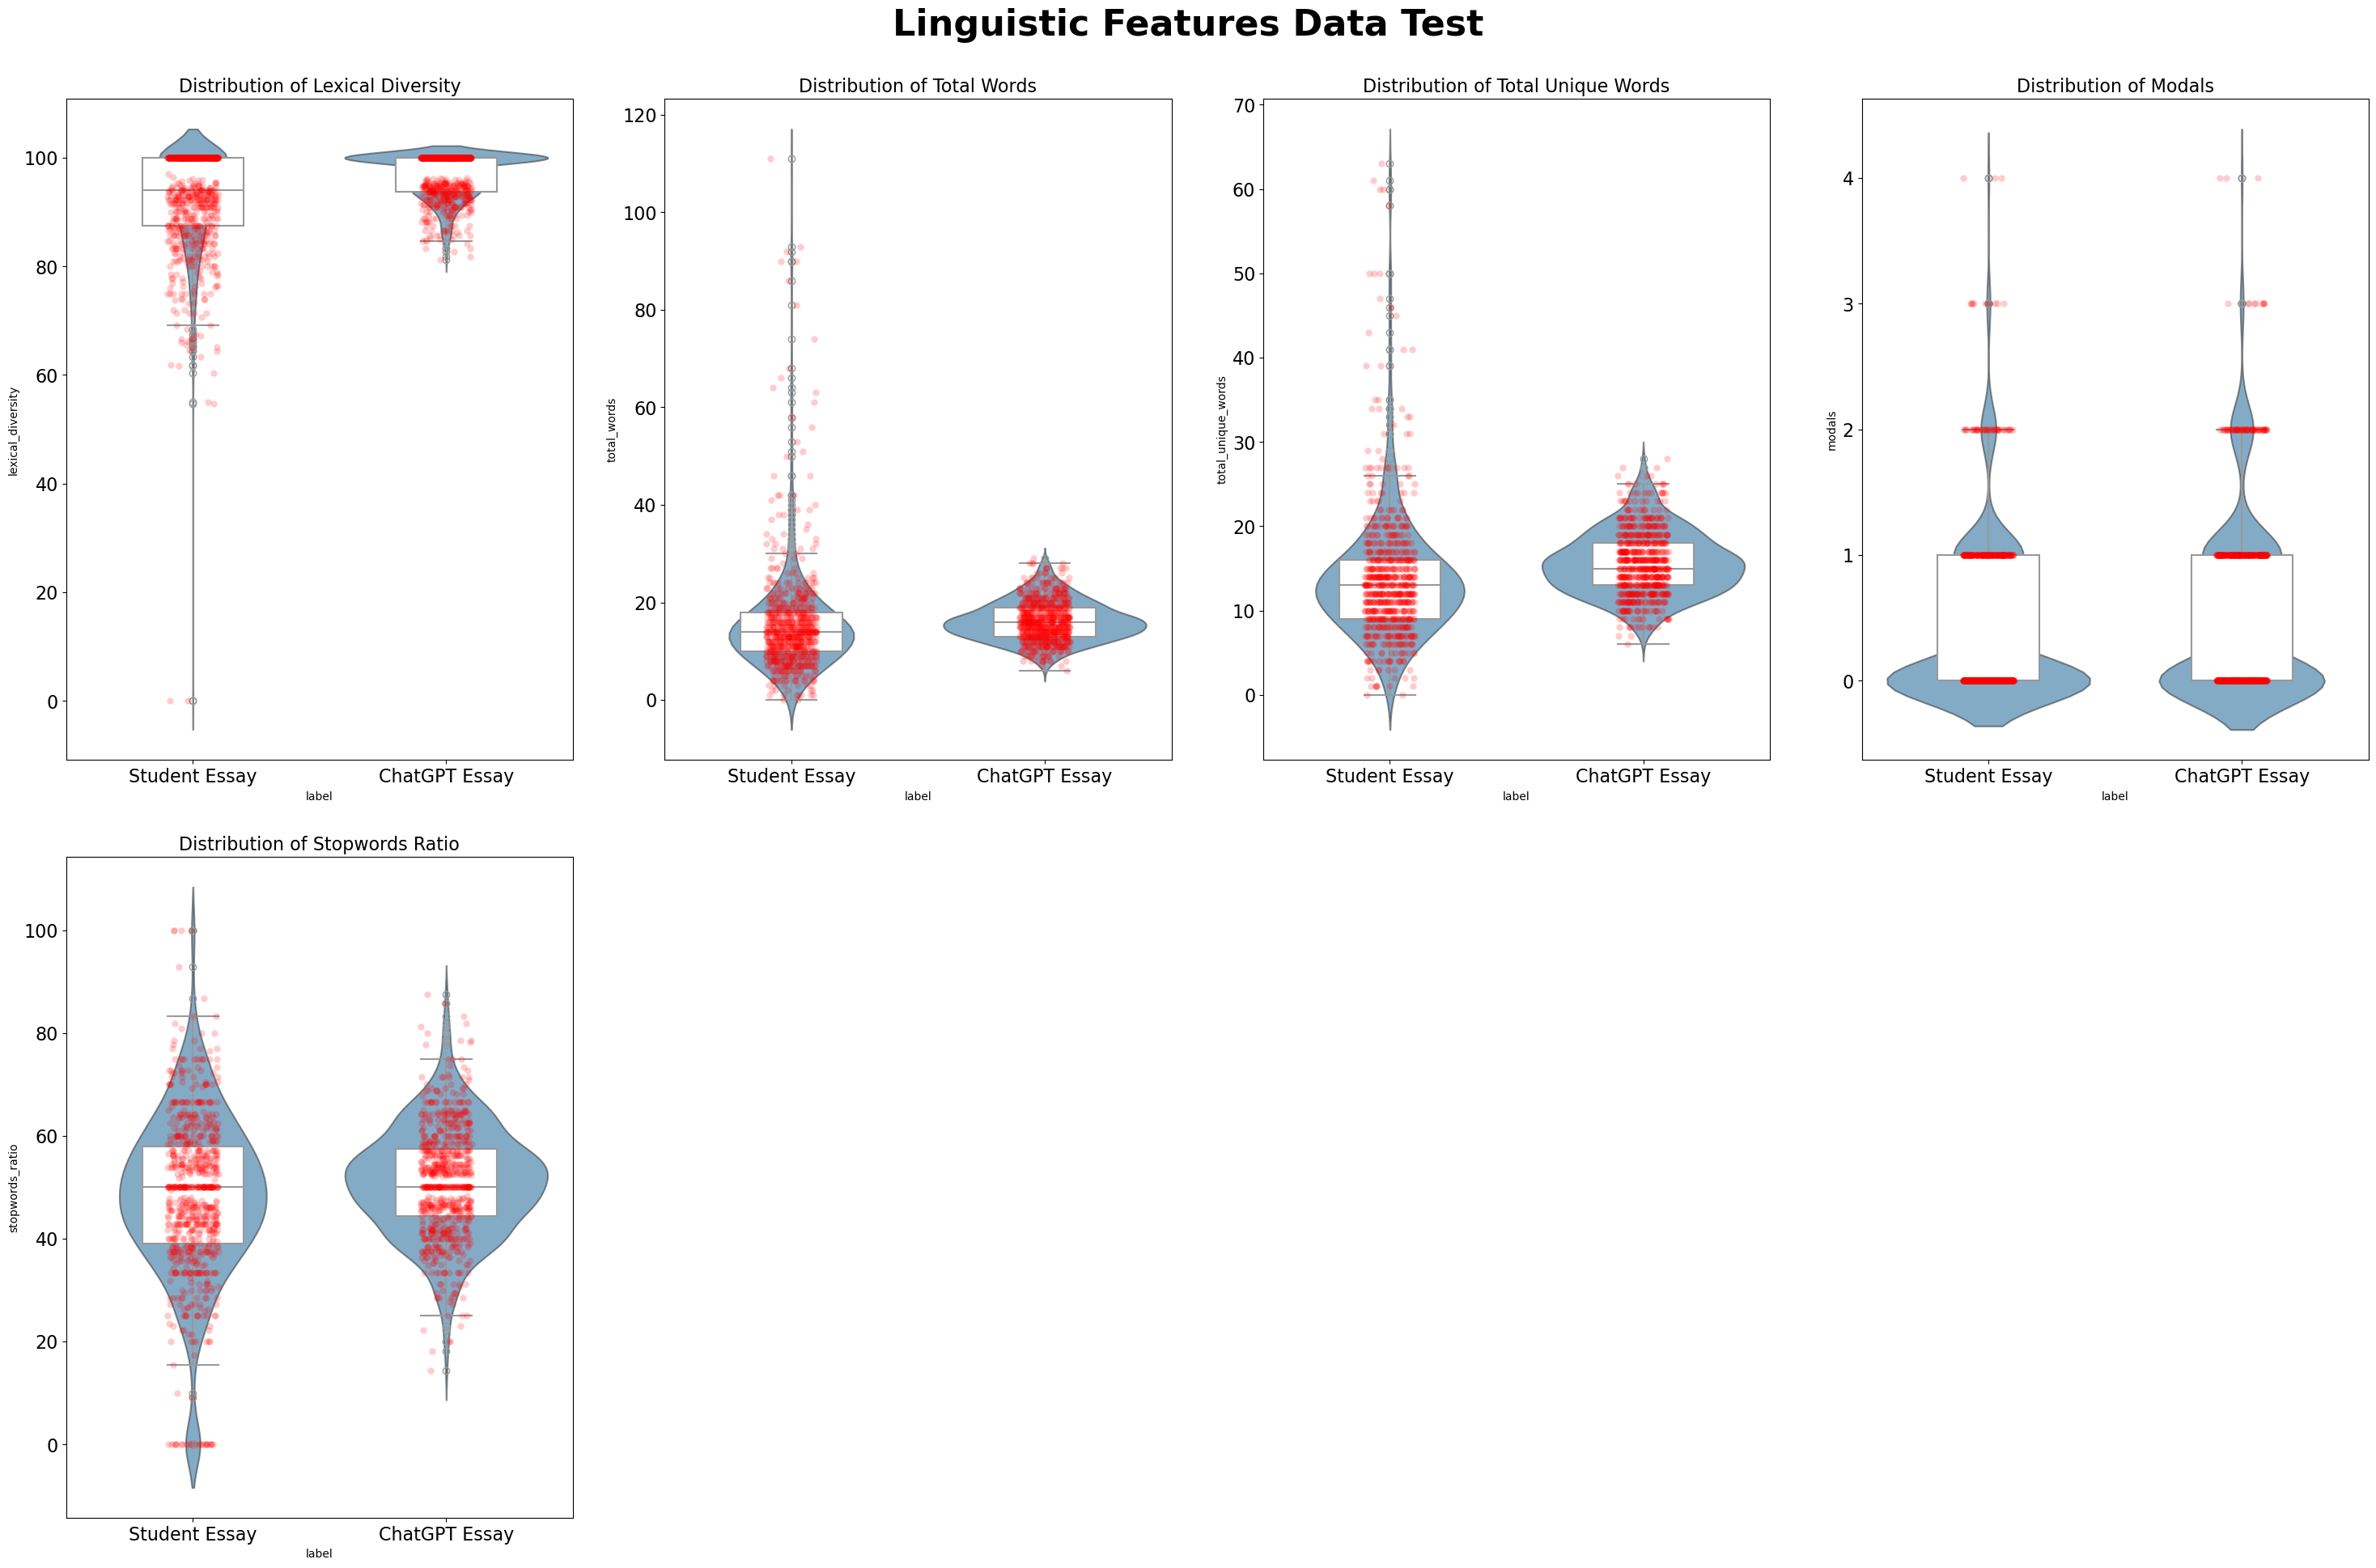

In [42]:
def new_func():
    plt.figure(figsize=(30, 20))
    for i, feature in enumerate([
    'lexical_diversity',
    'total_words',
    'total_unique_words',
    'modals',
    'stopwords_ratio',
]):
        plt.subplot(2, 4, i+1)
        sns.violinplot(x='label', y=feature, data=combined_tr_features, inner=None, alpha=0.6, linewidth=1.5)
        sns.boxplot(x='label', y=feature, data=combined_tr_features, width=0.4, 
                saturation=1, showfliers=True, color='white', linewidth=1.5)
        sns.stripplot(x='label', y=feature, data=combined_tr_features, color='red', alpha=0.2, size=6, jitter=True, dodge=True)
        plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

new_func()

plt.suptitle('Linguistic Features Data Test', fontsize=32, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.0)

plt.savefig('ta_sentence_2/images/linguistic_features_comparison(test).png', dpi=300, bbox_inches='tight')

plt.show()


In [43]:
# Check dimensions of your embedding arrays
print("std_te_emb shape:", std_te_emb.shape)
print("gpt1_te_emb shape:", gpt1_te_emb.shape)


# Print shapes of the resulting similarity scores
print("std_std_te_sim_scores shape:", np.array(std_std_te_sim_scores).shape)
print("std_gpt1_te_sim_scores shape:", np.array(std_gpt1_te_sim_scores).shape)
print("gpt1_std_te_sim_scores shape:", np.array(gpt1_std_te_sim_scores).shape)
print("gpt1_gpt1_te_sim_scores shape:", np.array(gpt1_gpt1_te_sim_scores).shape)

# Check shapes of the combined arrays
print("std_te_sim_scores shape:", std_te_sim_scores.shape)
print("gpt_te_sim_scores shape:", gpt_te_sim_scores.shape)

print("std_te_features_norm shape:", std_te_features_norm.shape)
print("gpt1_te_features_norm shape:", gpt_te_features_norm.shape)

std_te_emb shape: (205, 128)
gpt1_te_emb shape: (1295, 128)
std_std_te_sim_scores shape: (205,)
std_gpt1_te_sim_scores shape: (205,)
gpt1_std_te_sim_scores shape: (1295,)
gpt1_gpt1_te_sim_scores shape: (1295,)
std_te_sim_scores shape: (3, 205)
gpt_te_sim_scores shape: (3, 1295)
std_te_features_norm shape: (205, 5)
gpt1_te_features_norm shape: (1295, 5)


# Data Preparation for Classification

In [44]:
# Combine embeddings for model 1 (already correct)
emb_tr_features = np.vstack([std_tr_emb, gpt1_tr_emb])
emb_va_features = np.vstack([std_va_emb, gpt1_va_emb])
emb_te_features = np.vstack([std_te_emb, gpt1_te_emb])

std_tr_features_selected = std_tr_features_norm
gpt_tr_features_selected = gpt_tr_features_norm

std_va_features_selected = std_va_features_norm
gpt_va_features_selected = gpt_va_features_norm

std_te_features_selected = std_te_features_norm
gpt_te_features_selected = gpt_te_features_norm

linguistic_tr_features = np.vstack([
    std_tr_features_selected,
    gpt_tr_features_selected
])
linguistic_va_features = np.vstack([
    std_va_features_selected,
    gpt_va_features_selected
])
linguistic_te_features = np.vstack([
    std_te_features_selected,
    gpt_te_features_selected
])

std_tr_sim_scores_transposed = std_tr_sim_scores.T 
gpt_tr_sim_scores_transposed = gpt_tr_sim_scores.T
similarity_tr_scores = np.vstack([
    std_tr_sim_scores_transposed,
    gpt_tr_sim_scores_transposed,
])

std_va_sim_scores_transposed = std_va_sim_scores.T 
gpt_va_sim_scores_transposed = gpt_va_sim_scores.T
similarity_va_scores = np.vstack([
    std_va_sim_scores_transposed,
    gpt_va_sim_scores_transposed,
])
std_te_sim_scores_transposed = std_te_sim_scores.T 
gpt_te_sim_scores_transposed = gpt_te_sim_scores.T
similarity_te_scores = np.vstack([
    std_te_sim_scores_transposed,
    gpt_te_sim_scores_transposed,
])

# Create labels
std_tr_labels = np.zeros(len(train_set[train_set['label'] == 0]))
gpt_tr_labels = np.ones(len(train_set[train_set['label'] == 1]))
tr_labels = np.hstack([std_tr_labels, gpt_tr_labels])

# Validation set labels
std_va_labels = np.zeros(len(val_set[val_set['label'] == 0]))
gpt_va_labels = np.ones(len(val_set[val_set['label'] == 1]))
va_labels = np.hstack([std_va_labels, gpt_va_labels])

# Test set labels
std_te_labels = np.zeros(len(test_set[test_set['label'] == 0]))
gpt_te_labels = np.ones(len(test_set[test_set['label'] == 1]))
te_labels = np.hstack([std_te_labels, gpt_te_labels])

tr_labels = tr_labels.astype(int)
va_labels = va_labels.astype(int)
te_labels = te_labels.astype(int)

# Verify shapes
print(f"emb_te_features shape: {emb_te_features.shape}")
print(f"linguistic_te_features shape: {linguistic_te_features.shape}")
print(f"similarity_te_scores shape: {similarity_te_scores.shape}")
print(f"te_labels shape: {te_labels.shape}")

print(f"emb_te_features value: {emb_te_features[:5]}")
print(f"linguistic_te_features value: {linguistic_te_features[:5]}")
print(f"similarity_te_scores value: {similarity_te_scores[:5]}")
print(f"te_labels value: {te_labels[:5]}")


emb_te_features shape: (1500, 128)
linguistic_te_features shape: (1500, 5)
similarity_te_scores shape: (1500, 3)
te_labels shape: (1500,)
emb_te_features value: [[-9.10702497e-02 -5.77398688e-02  1.20389901e-01  7.45306984e-02
   4.17631641e-02  1.53807461e-01 -3.42197642e-02 -2.75972132e-02
  -7.37236962e-02  7.36601353e-02  2.26804912e-02  3.48892584e-02
  -1.40246332e-01  1.08509019e-01  1.33314461e-01 -1.14378054e-02
  -3.28444131e-02 -4.14586207e-03  4.23491634e-02 -1.35254577e-01
  -1.39515042e-01 -1.13729231e-01 -2.68587712e-02  5.96586913e-02
   1.41066760e-01 -6.14269860e-02 -6.78782314e-02 -2.48694178e-02
   1.08267970e-01  2.46904157e-02  5.62228709e-02 -7.15068132e-02
   6.32166639e-02 -4.52656634e-02  9.99881923e-02  5.67116141e-02
   1.65223926e-01  5.07368520e-02 -4.29556705e-02  5.03390059e-02
  -1.23432472e-01  1.90431438e-02  3.78227569e-02  5.78825399e-02
  -6.53594583e-02 -1.40661731e-01 -2.86554135e-02 -1.87725220e-02
   6.80050328e-02  3.50852460e-02  1.20174013e-

# Build Classification Model

In [45]:
emb_input = tf.keras.layers.Input(
    shape=(128,),
    dtype=tf.float32, 
    name="embeddings"
)

sim_score_input = tf.keras.layers.Input(
    shape=(3,), 
    dtype=tf.float32, 
    name="similarity_score"
)

linguistic_input = tf.keras.layers.Input(
    shape=(5,),
    dtype=tf.float32, 
    name="linguistic_features"
)

emb_dense = tf.keras.layers.Dense(128, activation="relu")(emb_input)
sim_dense = tf.keras.layers.Dense(16, activation="relu")(sim_score_input)
lin_dense = tf.keras.layers.Dense(64, activation="relu")(linguistic_input)

combined = tf.keras.layers.Concatenate()([emb_dense, sim_dense, lin_dense])

x = tf.keras.layers.Dense(128, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

classifier = tf.keras.Model(
    inputs=[emb_input, sim_score_input, linguistic_input],
    outputs=output,
    name="text_classifier"
)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

classifier.summary()

Model: "text_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embeddings (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 similarity_score (InputLay  [(None, 3)]                  0         []                            
 er)                                                                                              
                                                                                                  
 linguistic_features (Input  [(None, 5)]                  0         []                            
 Layer)                                                                                           
                                                                                    

# Create Data Input for Classification

In [46]:
train_inputs = {
    "embeddings": emb_tr_features,
    "similarity_score": similarity_tr_scores,
    "linguistic_features": linguistic_tr_features
}

val_inputs = {
    "embeddings": emb_va_features,
    "similarity_score": similarity_va_scores,
    "linguistic_features": linguistic_va_features
}


test_inputs = {
    "embeddings": emb_te_features,
    "similarity_score": similarity_te_scores,
    "linguistic_features": linguistic_te_features
}

train_labels = tr_labels
val_labels = va_labels
test_labels = te_labels

# Train Classification Model

Training Classification Model...
Epoch 1/30
96/96 [==============================] - 5s 16ms/step - loss: 0.5350 - accuracy: 0.8977 - precision: 0.9499 - recall: 0.8396 - auc: 0.9667 - val_loss: 0.3663 - val_accuracy: 0.9314 - val_precision: 0.9583 - val_recall: 0.9020 - val_auc: 0.9883
Epoch 2/30
96/96 [==============================] - 1s 13ms/step - loss: 0.2118 - accuracy: 0.9681 - precision: 0.9904 - recall: 0.9452 - auc: 0.9897 - val_loss: 0.1682 - val_accuracy: 0.9412 - val_precision: 0.9592 - val_recall: 0.9216 - val_auc: 0.9889
Epoch 3/30
96/96 [==============================] - 1s 12ms/step - loss: 0.0978 - accuracy: 0.9746 - precision: 0.9892 - recall: 0.9596 - auc: 0.9946 - val_loss: 0.1534 - val_accuracy: 0.9510 - val_precision: 0.9600 - val_recall: 0.9412 - val_auc: 0.9885
Epoch 4/30
96/96 [==============================] - 1s 13ms/step - loss: 0.0835 - accuracy: 0.9733 - precision: 0.9840 - recall: 0.9622 - auc: 0.9947 - val_loss: 0.1559 - val_accuracy: 0.9510 - val_prec

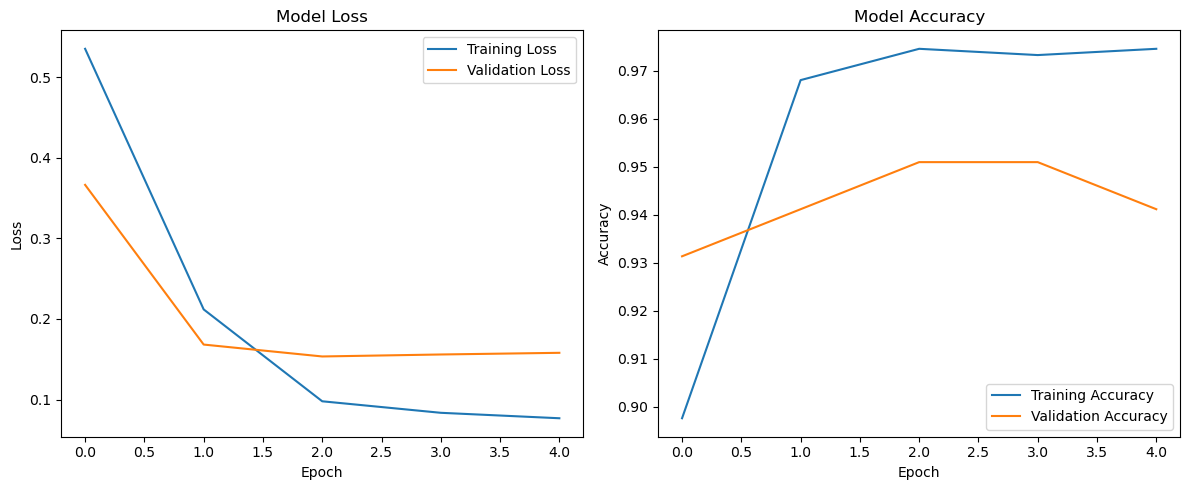

In [47]:
# Training classifier
print("Training Classification Model...")
history_classifier = classifier.fit(
    train_inputs,
    train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=30,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluation Model

Making predictions on training and validation data...
52/52 [==============================] - 0s 3ms/step
Generating ROC curve...


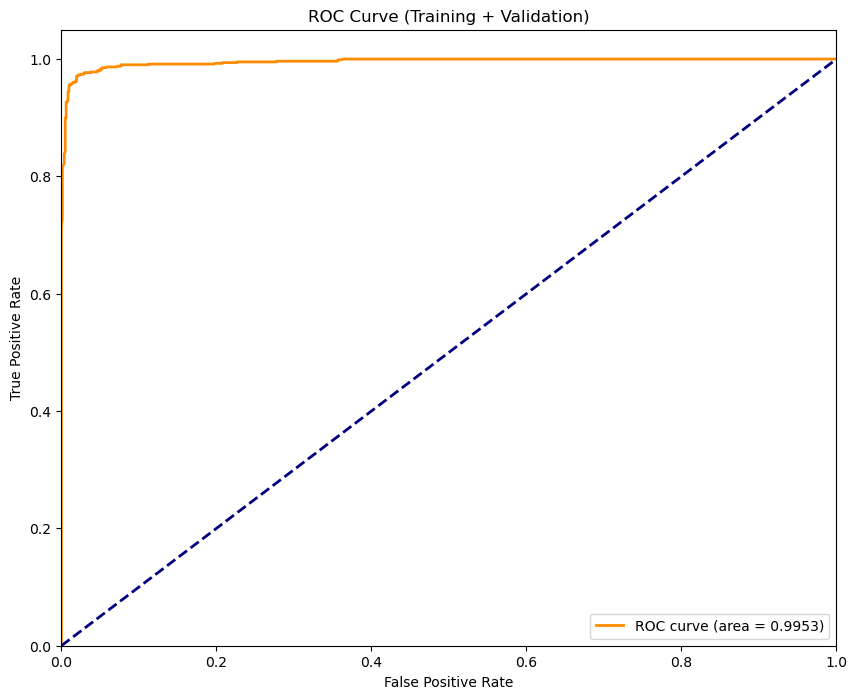

Analyzing threshold performance...


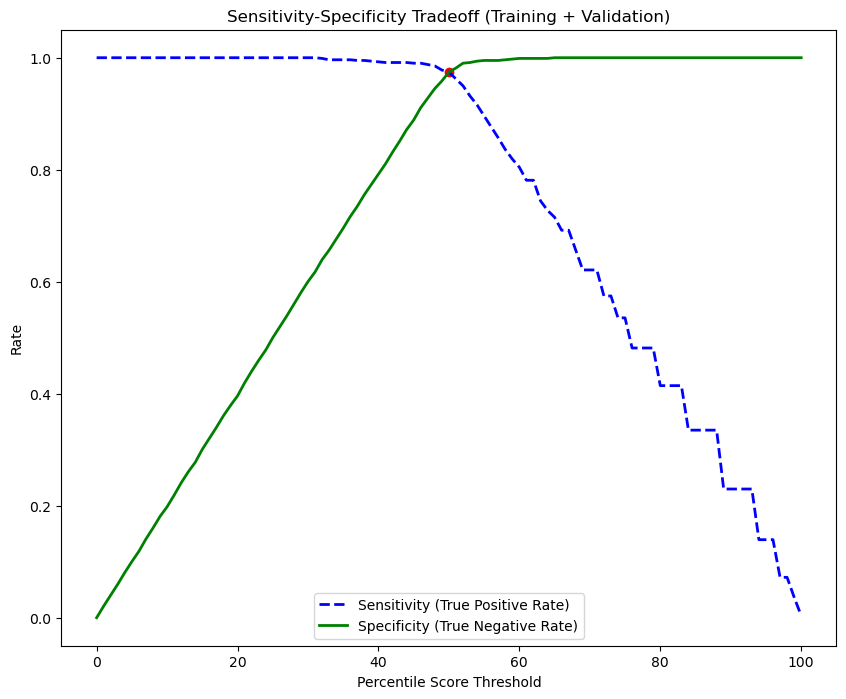

Threshold points with equal sensitivity and specificity:
Percentile: 50.0, Threshold: 0.2280, Rate: 0.9743
Selected optimal threshold: 0.2280


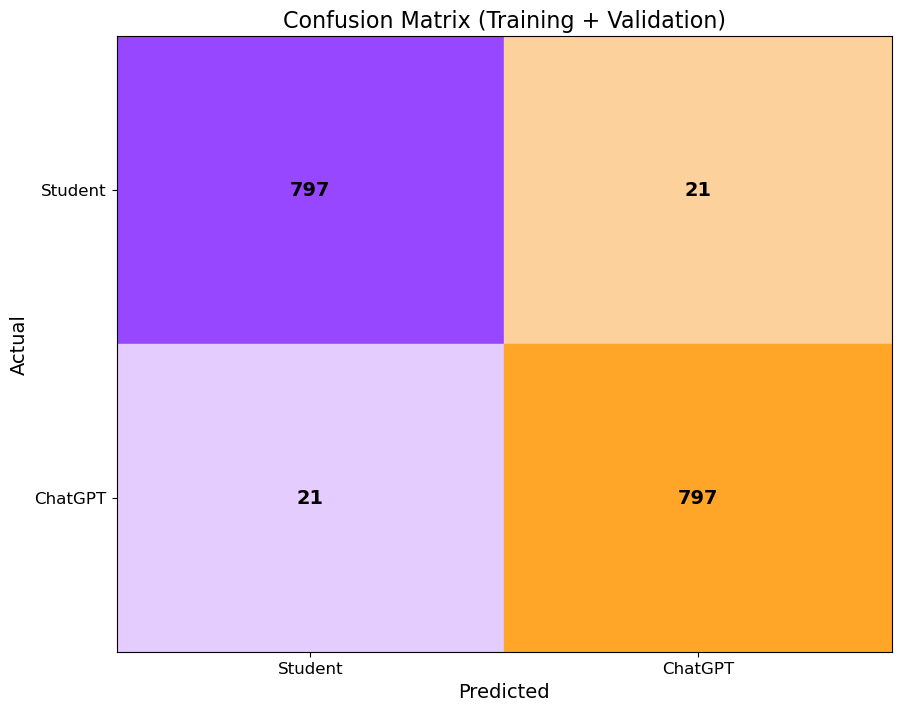


Detailed Classification Report (Training + Validation):
              precision    recall  f1-score   support

     Student       0.97      0.97      0.97       818
     ChatGPT       0.97      0.97      0.97       818

    accuracy                           0.97      1636
   macro avg       0.97      0.97      0.97      1636
weighted avg       0.97      0.97      0.97      1636



In [48]:
# Combine only training and validation inputs and labels (excluding test data)
combined_inputs = {
    "embeddings": np.concatenate([train_inputs["embeddings"], val_inputs["embeddings"]]),
    "similarity_score": np.concatenate([train_inputs["similarity_score"], val_inputs["similarity_score"]]),
    "linguistic_features": np.concatenate([train_inputs["linguistic_features"], val_inputs["linguistic_features"]])
}
combined_labels = np.concatenate([train_labels, val_labels])

# Make predictions on combined training and validation data
print("Making predictions on training and validation data...")
combined_predictions = classifier.predict(combined_inputs)

# Calculate ROC curve and plot
print("Generating ROC curve...")
fpr, tpr, _ = roc_curve(combined_labels, combined_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training + Validation)')
plt.legend(loc="lower right")
plt.savefig('ta_sentence_2/images/roc_curve (train_val).png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate performance at different thresholds
print("Analyzing threshold performance...")
percentiles = np.linspace(0, 100, num=101)
sensitivity_data = []  
specificity_data = [] 
intersection_points = []

for p in percentiles:
    threshold = np.percentile(combined_predictions, p)
    predictions_binary = (combined_predictions >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(combined_labels, predictions_binary).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivity_data.append(sensitivity)
    specificity_data.append(specificity)
    
    # Identify where sensitivity and specificity are approximately equal
    if np.isclose(sensitivity, specificity, atol=1e-2):
        intersection_points.append((p, threshold, sensitivity))

# Plot sensitivity-specificity tradeoff
plt.figure(figsize=(10, 8))
plt.plot(percentiles, sensitivity_data, label='Sensitivity (True Positive Rate)', color='blue', lw=2, linestyle='--')
plt.plot(percentiles, specificity_data, label='Specificity (True Negative Rate)', color='green', lw=2)

# Highlight balanced points
for p, threshold, rate in intersection_points:
    plt.scatter(p, rate, color='red')

plt.xlabel('Percentile Score Threshold')
plt.ylabel('Rate')
plt.title('Sensitivity-Specificity Tradeoff (Training + Validation)')
plt.legend(loc="best")
plt.savefig('ta_sentence_2/images/tradeoff_with_intersections (train_val).png', dpi=300, bbox_inches='tight')
plt.show()

print("Threshold points with equal sensitivity and specificity:")
for p, threshold, rate in intersection_points:
    print(f"Percentile: {p:.1f}, Threshold: {threshold:.4f}, Rate: {rate:.4f}")

if intersection_points:
    _, optimal_threshold, _ = intersection_points[0]
else:
    optimal_threshold = np.percentile(combined_predictions, 50)

print(f"Selected optimal threshold: {optimal_threshold:.4f}")

# Apply optimal threshold for final predictions
combined_predictions_binary = (combined_predictions >= optimal_threshold).astype(int)

# Generate confusion matrix with custom styling
cm_combined = confusion_matrix(combined_labels, combined_predictions_binary)

# Define custom colors for confusion matrix
colors = np.array([
    ["#9747FF", "#FCD19C"],  
    ["#E4CCFF", "#FFA629"]
])

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
rows, cols = cm_combined.shape
row_ind, col_ind = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

for i in range(rows):
    for j in range(cols):
        plt.fill_between([j, j+1], [rows-i-1, rows-i-1], [rows-i, rows-i], color=colors[i, j])
        plt.text(j+0.5, rows-i-0.5, str(cm_combined[i, j]), ha='center', va='center', 
                 color='black', fontsize=14, fontweight='bold')

plt.title('Confusion Matrix (Training + Validation)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0.5, 1.5], ['Student', 'ChatGPT'], fontsize=12)
plt.yticks([0.5, 1.5], ['ChatGPT', 'Student'], fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.savefig('ta_sentence_2/images/confusion_matrix(train_val).png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nDetailed Classification Report (Training + Validation):")
print(classification_report(combined_labels, combined_predictions_binary, target_names=['Student', 'ChatGPT']))

Making predictions on test dataset...
47/47 [==============================] - 0s 3ms/step


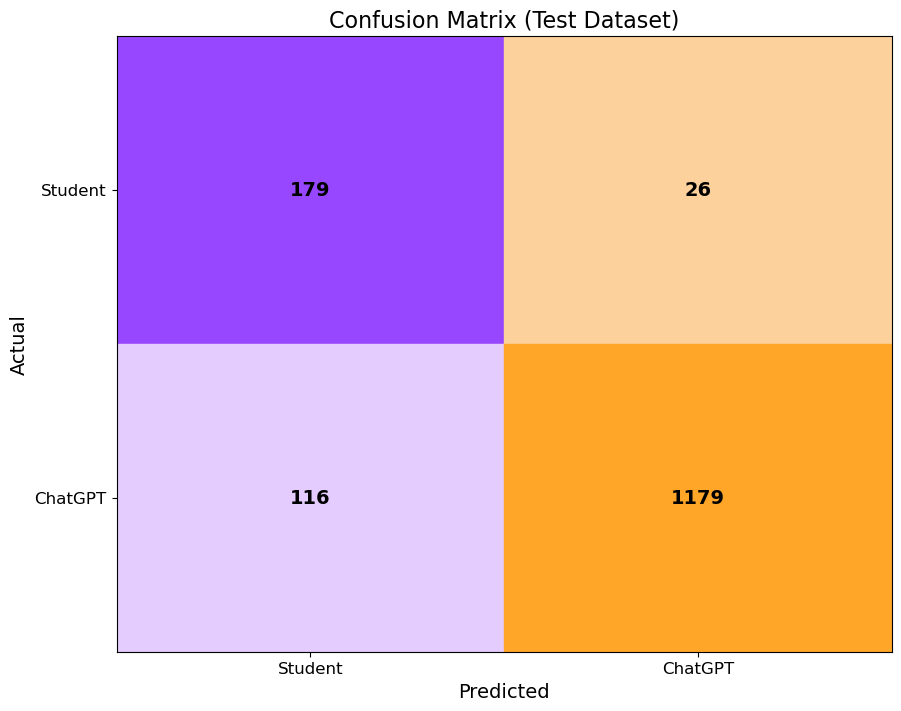


Detailed Classification Report (test set):
              precision    recall  f1-score   support

     Student       0.61      0.87      0.72       205
     ChatGPT       0.98      0.91      0.94      1295

    accuracy                           0.91      1500
   macro avg       0.79      0.89      0.83      1500
weighted avg       0.93      0.91      0.91      1500



In [49]:
# Make predictions on test data only
print("Making predictions on test dataset...")
test_predictions = classifier.predict(test_inputs)

test_predictions_binary = (test_predictions >= optimal_threshold).astype(int)

cm_test = confusion_matrix(test_labels, test_predictions_binary)

# Define custom colors for confusion matrix
colors = np.array([
    ["#9747FF", "#FCD19C"],  
    ["#E4CCFF", "#FFA629"]
])

# Visualize confusion matrix for test data
plt.figure(figsize=(10, 8))
rows, cols = cm_test.shape
row_ind, col_ind = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

for i in range(rows):
    for j in range(cols):
        plt.fill_between([j, j+1], [rows-i-1, rows-i-1], [rows-i, rows-i], color=colors[i, j])
        plt.text(j+0.5, rows-i-0.5, str(cm_test[i, j]), ha='center', va='center', 
                 color='black', fontsize=14, fontweight='bold')

plt.title('Confusion Matrix (Test Dataset)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0.5, 1.5], ['Student', 'ChatGPT'], fontsize=12)
plt.yticks([0.5, 1.5], ['ChatGPT', 'Student'], fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.savefig('ta_sentence_2/images/confusion_matrix (test set).png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report for test data
print("\nDetailed Classification Report (test set):")
print(classification_report(test_labels, test_predictions_binary, target_names=['Student', 'ChatGPT']))

# Misclassified Essay Report

In [50]:
misclassified_students = []
misclassified_chatgpt = []
test_actual_texts = test_set['text'].values
similarity_scores = test_inputs['similarity_score']

for i, (actual, pred) in enumerate(zip(test_labels, test_predictions_binary)):
    if actual == 0 and pred == 1:
        student_idx = i
        most_similar_chatgpt = None
        highest_similarity = -1
        avg_similarity_to_chatgpt = similarity_scores[i][1]
        for j, gpt_text in enumerate(gpt1_sen):
            if j < len(gpt1_te_emb):
                student_embedding = tf.expand_dims(std_te_emb[student_idx], 0) if student_idx < len(std_te_emb) else None
                chatgpt1_embedding = tf.expand_dims(gpt1_te_emb[j], 0)
                
                if student_embedding is not None:
                    similarity = cos_sim(student_embedding, chatgpt1_embedding)
                    
                    if similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_chatgpt = gpt1_sen[j]
        
        misclassified_students.append({
            'Type': 'False Positive',
            'Text': test_actual_texts[i], 
            'Model Confidence': test_predictions[i][0],
            'Avg. Similarity': avg_similarity_to_chatgpt,
            'Most Similar Text': most_similar_chatgpt,
            'Similarity Score': highest_similarity
        })
    elif actual == 1 and pred == 0:
        chatgpt_idx = i
        most_similar_student = None
        highest_similarity = -1
        avg_similarity_to_student = similarity_scores[i][0]
        for j, std_text in enumerate(std_sen):
            if j < len(std_te_emb):
                chatgpt1_embedding = tf.expand_dims(gpt1_te_emb[chatgpt_idx-len(std_te_emb)], 0) if chatgpt_idx >= len(std_te_emb) else None
                student_embedding = tf.expand_dims(std_te_emb[j], 0)
                
                if chatgpt1_embedding is not None:
                    similarity = cos_sim(chatgpt1_embedding, student_embedding)
                    
                    if similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_student = std_sen[j]
        
        misclassified_chatgpt.append({
            'Type': 'False Negative', 
            'Text': test_actual_texts[i], 
            'Model Confidence': 1 - test_predictions[i][0],
            'Avg. Similarity': avg_similarity_to_student,
            'Most Similar Text': most_similar_student,
            'Similarity Score': highest_similarity
        })

sorted_misclassified_students = sorted(
    misclassified_students, 
    key=lambda x: (x['Similarity Score'], x['Avg. Similarity'], x['Model Confidence']),
    reverse=True
)

sorted_misclassified_chatgpt = sorted(
    misclassified_chatgpt, 
    key=lambda x: (x['Similarity Score'], x['Avg. Similarity'], x['Model Confidence']),
    reverse=True
)

print("Top 3 Student Essays Misclassified as ChatGPT (by Similarity):")
display(pd.DataFrame(sorted_misclassified_students).head(3))

print("\nTop 2 ChatGPT Essays Misclassified as Student (by Similarity):")
display(pd.DataFrame(sorted_misclassified_chatgpt).head(2))

Top 3 Student Essays Misclassified as ChatGPT (by Similarity):


,Type,Text,Model Confidence,Avg. Similarity,Most Similar Text,Similarity Score
0,False Positive,"bahkan, beberapa aplikasi belajar daring saya manfaatkan untuk menambah pengetahuan baru secara santai di sela-sela waktu berlibur.",0.989258,0.610990,"secara keseluruhan, teknologi telah menjadi aset berharga dalam membuat libur idul fitri kali ini tetap meriah dan bermakna, meski dengan segala keterbatasan yang ada.",0.972736
1,False Positive,"selain itu, saya juga menggunakan media sosial untuk membagikan momen-momen kebahagiaan saat idul fitri.",0.981934,0.578339,teknologi memungkinkan saya untuk berbagi kebahagiaan dan harapan baik meskipun jarak memisahkan kita.,0.963657
2,False Positive,libur kali ini memberi saya waktu berkumpul lebih lama bersama keluarga.,0.995117,0.622443,fitur editing yang ada di aplikasi media sosial membantu saya untuk membuat kolase dan video yang kemudian saya unggah.,0.945558



Top 2 ChatGPT Essays Misclassified as Student (by Similarity):


,Type,Text,Model Confidence,Avg. Similarity,Most Similar Text,Similarity Score
0,False Negative,"biasanya, saya akan mudik ke kampung halaman bersama keluarga.",0.981842,0.830802,"lebaran hari kelima, ketupat dan opor masih ada sisa.",0.979948
1,False Negative,"saya mencoba beberapa resep yang saya temukan, dan hasilnya cukup memuaskan.",0.983337,0.806506,pada saat bulan ramadhan dari tanggal 28 februari sampai tanggal 30 2025 saya awali dengan sholat shubuh berjamaah.,0.963512


# Save Model

In [51]:
reference_embeddings = {
    'embeddings_std_sen': {
        'embeddings': std_emb,
    },
    'embeddings_gpt1_sen': {
        'embeddings': gpt1_emb,
    },
    'embeddings_gpt2_sen': {
        'embeddings': gpt2_emb,
    }
}

In [52]:
if not os.path.exists('ta_sentence_2'):
    os.makedirs('ta_sentence_2')

with open('ta_sentence_2/reference_embeddings.pkl', 'wb') as f:
    pickle.dump(reference_embeddings, f)

semantic_model.save('ta_sentence_2/semantic_model.h5')
classifier.save('ta_sentence_2/classification_model.h5')

tokenizer.save_pretrained('ta_sentence_2/tokenizer')

with open("ta_sentence_2/scaler_linguistic.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and configuration successfully saved!")

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and configuration successfully saved!


In [53]:
%load_ext watermark
%watermark
%watermark -iv --gpu

Last updated: 2025-06-13T13:25:51.605843+07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

pandas      : 2.2.2
matplotlib  : 3.9.2
re          : 2.2.1
numpy       : 1.26.4
transformers: 4.49.0
sklearn     : 1.5.1
imblearn    : 0.12.3
tensorflow  : 2.19.0
seaborn     : 0.13.2

GPU Info: 
  GPU 0: NVIDIA GeForce GTX 1660 SUPER

